In [417]:
%matplotlib inline
import glob, os, sys, timeit
import matplotlib
import numpy as np
from astropy.io import fits,ascii
from astropy import constants, units as u
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from os import path
import os
from urllib import request

from pyqsofit import PyQSOFit
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, TriAnalyzer

import warnings
from importlib import reload

reload(PyQSOFit)

multiAGNpath="/disk/bifrost/yuanze/multiAGN"
psname1="UGC"
psname2="2369"
field=psname1+psname2
stab = ascii.read(multiAGNpath+"/sources.list",format="ipac")
field=psname1+psname2
sentry = stab[stab["Field"]==field]
RA=sentry["RA"].value#[43.507814008,43.507573386,43.50724857]
Dec=sentry["Dec"].value#[14.9700775,14.9708075,14.97041556]

redshift=0.0318
#redshift=sentry["z_sys"][-1]
datapath=os.path.join(multiAGNpath,psname1+psname2)

path_out=datapath+"/field_scan_kcwi"
path_ex = datapath #os.path.join(pyqsofit.__path__[0], '..', 'example')

## line prior

In [391]:
##=================================set-up 1========================#
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""


# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Yuanze Ding'
primary_hdu = fits.PrimaryHDU(header=hdr0)

line_priors = np.rec.array([
    (5889.950, 'Ha', 5600, 6000, 'NaI5890', 1, .1, 0.0, 1e1, 1e-5, 2.3e-7, 1.5e-3, -5e-3,1e-5, 1, 0, 1, 0.2, 1),
    (5895.924, 'Ha', 5600, 6000, 'NaI5896', 1, .1, 0.0, 1e1, 1e-5, 2.3e-7, 1.5e-3,-5e-3,1e-5, 1, 0, 1, 0.1, 1),
    (5889.950, 'Ha', 5600, 6000, 'NaI5890w1', 1, .1, 0.0, 1e1, 6e-4, 2.3e-4, 5e-3,-5e-3,1e-5, 2, 0, 2, 0.2, 1),
    (5895.924, 'Ha', 5600, 6000, 'NaI5896w1', 1, .1, 0.0, 1e1, 6e-4, 2.3e-4, 5e-3,-5e-3,1e-5, 2, 0, 2, 0.1, 1),
    (5889.950, 'Ha', 5600, 6000, 'NaI5890w2', 1, .1, 0.0, 1e1, 3e-5, 2.3e-7,1.5e-3,-5e-3,1e-5, 3, 0, 3, 0.2, 1),
    (5895.924, 'Ha', 5600, 6000, 'NaI5896w2', 1, .1, 0.0, 1e1, 3e-5, 2.3e-7,1.5e-3,-5e-3,1e-5, 3, 0, 3, 0.1, 1),
    (5875.621, 'Ha', 5600, 6000, 'HeI5876', 1, 1.0, 0.0, 50, 1e-4, 2.3e-7, 1.5e-3, -5e-3,1e-4, 0, 0, 0, 0.001, 1),
    (5895.924, 'Ha', 5600, 6000, 'NaI5896emit',1, 1.0, 0.0, 20, 5e-4, 2.3e-6,1.6e-3,-5e-4,5e-4, 0, 0, 0, 0.1, 1)
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig, minvoff,maxvoff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['minvoff  '] = 'Lower Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['maxvoff  '] = 'Upper Limits on velocity offset from the central wavelength [lnlambda]'

hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

##=================================set-up 2========================#
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (4700., 4800.), # added window
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')
#====================================set-up 3==================================#
conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  0), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 0), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  0), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 0), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     0.0,   0.0,   1e10,  0), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   0), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  0), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 0), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.0,   0.1,   2.0,   0), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  0), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  0), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  0), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

#====================================set-up 4==================================#

"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[4600, 5100, 6400, 8000]],
        [[
            # [2240, 2650], 
            [5100, 5485],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'NaI_field_kcwi.fits'), overwrite=True)

## Full line prior

In [348]:
##=================================set-up 1========================#
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""


# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Yuanze Ding'
primary_hdu = fits.PrimaryHDU(header=hdr0)

line_priors = np.rec.array([
    (5889.950, 'Ha', 4640, 6800, 'NaI5890', 1, .1, 0.0, 1e1, 1e-5, 2.3e-7, 1.5e-3, -5e-3,5e-4, 4, 0, 1, 0.2, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896', 1, .1, 0.0, 1e1, 1e-5, 2.3e-7, 1.5e-3,-5e-3,5e-4, 4, 0, 1, 0.1, 1),
    (5889.950, 'Ha', 4640, 6800, 'NaI5890w1', 1, .1, 0.0, 1e1, 6e-4, 2.3e-4, 5e-3,-5e-3,5e-4, 5, 0, 2, 0.2, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896w1', 1, .1, 0.0, 1e1, 6e-4, 2.3e-4, 5e-3,-5e-3,5e-4, 5, 0, 2, 0.1, 1),
    #(5889.950, 'Ha', 4640, 6800, 'NaI5890w2', 1, .1, 0.0, 1e1, 3e-5, 2.3e-7, 1.5e-3,-5e-3,1e-3, 6, 0, 3, 0.2, 1),
    #(5895.924, 'Ha', 4640, 6800, 'NaI5896w2', 1, .1, 0.0, 1e1, 3e-5, 2.3e-7, 1.5e-3,-5e-3,1e-3, 6, 0, 3, 0.1, 1),
#    (6564.61, 'Ha', 6400, 6800, 'Ha_br',   2, 0.0, 0.0, 1e10, 5e-3, 4e-4,     0.05,0.015, 0, 0, 0, 0.05, 1),
    #(6549.85, 'Ha', 6400, 6800, 'NII6549_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6585.28, 'Ha', 6400, 6800, 'NII6585_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6300.30, 'Ha', 4640, 6800, 'OI6300',   1, 0.0, 0.0, 1e10, 1e-4, 1.e-7, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6564.61, 'Ha', 4640, 6800, 'Ha_na',   2, 1.0, 0.0, 1e10, 1e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 4640, 6800, 'NII6549', 2, 1.0, 0.0, 1e10, 1e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 1, 1, 10, 0.1, 1),
    (6585.28, 'Ha', 4640, 6800, 'NII6585', 2, 1.0, 0.0, 1e10, 1e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 1, 1, 10, 0.3, 1),
    (6718.29, 'Ha', 4640, 6800, 'SII6718', 2, 1.0, 0.0, 1e10, 1e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 1, 1, 0, 0.001, 1),
    (6732.67, 'Ha', 4640, 6800, 'SII6732', 2, 1.0, 0.0, 1e10, 1e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 1, 1, 0, 0.001, 1),
    (5875.621, 'Ha', 4640, 6800, 'HeI5876', 1, 1.0, 0.0, 50, 1e-4, 2.3e-7, 1.5e-3, -1e-3,1e-3, 0, 1, 0, 0.001, 1),
    
    #(6564.61, 'Ha', 4640, 6800, 'Ha_naw',  1, .5, 0.0, 1e10, 3e-4, 1.e-7,   1.5e-3, 5e-3, 3, 3, 0, 0.002, 1),
    #(6549.85, 'Ha', 4640, 6800, 'NII6549w', 1, .5, 0.0, 1e10, 3e-4, 1.e-7, 1.5e-3, 5e-3, 3, 3, 20, 0.1, 1),
    #(6585.28, 'Ha', 4640, 6800, 'NII6585w', 1, .5, 0.0, 1e10, 3e-4, 1.e-7, 1.5e-3, 5e-3, 3, 3, 20, 0.3, 1),
    #(6718.29, 'Ha', 4640, 6800, 'SII6718w', 1, .5, 0.0, 1e10, 3e-4, 1.e-7, 1.5e-3, 5e-3, 3, 3, 0, 0.001, 1),
    #(6732.67, 'Ha', 4640, 6800, 'SII6732w', 1, .5, 0.0, 1e10, 3e-4, 1.e-7, 1.5e-3, 5e-3, 3, 3, 0, 0.001, 1),
#FWHM = 2.355*2.3e-4*c0.
#    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,        0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Ha', 4640, 6800, 'Hb_na', 1, 1.0, 0.0, 1e10,    1e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 11, 11, 0, 0.002, 1),
    (4862.68, 'Ha', 4640, 6800, 'Hb_naw', 1, 1.0, 0.0, 1e10,   3e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 31, 31, 0, 0.002, 1),
    (4960.30, 'Ha', 4640, 6800, 'OIII4959c', 1, 1.0, 0.0, 1e10,1e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 11, 11, 40, 1.00, 1),
    (5008.24, 'Ha', 4640, 6800, 'OIII5007c', 1, 1.0, 0.0, 1e10,1e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 11, 11, 40, 2.98, 1),
    (4960.30, 'Ha', 4640, 6800, 'OIII4959w',  1, 1.0, 0.0,1e10,3e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 31, 31, 41, 1.00, 1),
    (5008.24, 'Ha', 4640, 6800, 'OIII5007w', 1, 1.0, 0.0, 1e10,3e-4, 1.e-7, 1.5e-3, -5e-3,5e-3, 31, 31, 41, 2.98, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896emit',1, 1.0, 0.0, 20, 5e-4, 2.3e-6,1.6e-3,-1e-3,5e-3, 0, 0, 0, 0.1, 1)
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig, minvoff,maxvoff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['minvoff  '] = 'Lower Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['maxvoff  '] = 'Upper Limits on velocity offset from the central wavelength [lnlambda]'

hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

##=================================set-up 2========================#
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (4700., 4800.), # added window
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')
#====================================set-up 3==================================#
conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  0), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 0), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  0), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 0), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     0.0,   0.0,   1e10,  0), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   0), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  0), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 0), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.0,   0.1,   2.0,   0), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  0), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  0), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  0), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

#====================================set-up 4==================================#

"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[4600, 5100, 6400, 8000]],
        [[
            # [2240, 2650], 
            [5100, 5485],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar_field_kcwi.fits'), overwrite=True)

## line prior lowsn

In [189]:
##=================================set-up 1========================#
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

path_ex = datapath #os.path.join(pyqsofit.__path__[0], '..', 'example')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Yuanze Ding'
primary_hdu = fits.PrimaryHDU(header=hdr0)

line_priors = np.rec.array([
    (5889.950, 'Ha', 4640, 6800, 'NaI5890', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, 1e-2, 4, 0, 1, 0.2, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, 1e-2, 4, 0, 1, 0.1, 1),
#    (6564.61, 'Ha', 6400, 6800, 'Ha_br',   2, 0.0, 0.0, 1e10, 5e-3, 4e-4,     0.05,0.015, 0, 0, 0, 0.05, 1),
    #(6549.85, 'Ha', 6400, 6800, 'NII6549_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6585.28, 'Ha', 6400, 6800, 'NII6585_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    
    (6564.61, 'Ha', 4640, 6800, 'Ha_na',   1, 0.0, 0.0, 1e10, 1e-3, 1.e-7, 0.00169, 5e-3, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 4640, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    (6585.28, 'Ha', 4640, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-7, 0.00169, 5e-3, 1, 1, 0, 0.003, 1),
    (6718.29, 'Ha', 4640, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    (6732.67, 'Ha', 4640, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),

#FWHM = 2.355*2.3e-4*c0.
#    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,        0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Ha', 4640, 6800, 'Hb_na', 2, 0.0, 0.0, 1e10, 1e-3, 1.e-7, 0.00169,     5e-3, 1, 1, 0, 0.002, 1),
    (4960.30, 'Ha', 4640, 6800, 'OIII4959c', 2, 0.0, 0.0, 1e10, 1e-3, 1.e-7, 0.00169, 5e-3, 1, 1, 0, 0.002, 1),
    (5008.24, 'Ha', 4640, 6800, 'OIII5007c', 2, 0.0, 0.0, 1e10, 1e-3, 1.e-7, 0.00169, 5e-3, 1, 1, 0, 0.004, 1),
    (5875.621, 'Ha', 4640, 6800, 'HeI5876', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 0, 0, 0.001, 1),
#    (5895.924, 'Ha', 4640, 6800, 'NaI5896emit', 1, 0.0, 0.0, 500, 5e-4, 2.3e-6, 1.6e-3, 5e-3, 0, 0, 0, 0.1, 1)

    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

##=================================set-up 2========================#
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (4700., 4800.), # added window
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')
#====================================set-up 3==================================#
conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  0), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 0), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  0), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 0), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     0.0,   0.0,   1e10,  0), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   0), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  0), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 0), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.0,   0.1,   2.0,   0), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  0), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  0), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  0), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

#====================================set-up 4==================================#

"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[4600, 5100, 6400, 8000]],
        [[
            # [2240, 2650], 
            [5100, 5485],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar_field_lowsn_kcwi.fits'), overwrite=True)

## Read in data and start fitting

In [439]:

rootname=field+"bin35-SNRcut"
gistoutpath=datapath+"/gist-KCWI/results/"+rootname

dirprefix=os.path.join(gistoutpath,rootname)

mask = fits.open(dirprefix+'_mask.fits')[1].data.MASK_DEFUNCT
maskedSpaxel = np.array(mask, dtype=bool)
#nmask=table_hdu[1].data.FLUX<0
#maskedSpaxel=nmask|masked
# Read bintable
table_hdu = fits.open(dirprefix+'_table.fits')
X           = np.array( table_hdu[1].data.X[~maskedSpaxel] )
Y           = np.array( table_hdu[1].data.Y[~maskedSpaxel] )
FLUX        = np.array( table_hdu[1].data.FLUX[~maskedSpaxel] ) 
binNum_long = np.array( table_hdu[1].data.BIN_ID[~maskedSpaxel] )
ubins       = np.unique( np.abs(binNum_long) )
pixelsize   = table_hdu[0].header['PIXSIZE']

Spectra    = fits.open(dirprefix+'_BinSpectra.fits')[1].data.SPEC
ESpectra = fits.open(dirprefix+'_BinSpectra.fits')[1].data.ESPEC
Lambda     = fits.open(dirprefix+'_BinSpectra.fits')[2].data.LOGLAM
nbins           = Spectra.shape[0]


sfhBestfit = fits.open(dirprefix+'_sfh-bestfit.fits')[1].data.BESTFIT
sfhLambda  = fits.open(dirprefix+'_sfh-bestfit.fits')[2].data.LOGLAM
sfhGoodpix = fits.open(dirprefix+'_sfh-bestfit.fits')[3].data.GOODPIX
        

In [440]:
import sys
sys.path.append('/disk/bifrost/yuanze/software/gist-development')
from gistPipeline.auxiliary._auxiliary import getLSF
from gistPipeline.prepareTemplates import xsl_lin
config={'PREPARE_TEMPLATES':{},'GENERAL':{}}
config['GENERAL']['CONFIG_DIR']="/disk/bifrost/yuanze/multiAGN/UGC2369/gist-KCWI/configFiles"
config['GENERAL']['LSF_DATA']="lsf_KCWI_BR"
config['GENERAL']['LSF_TEMP']="lsf_XSL"
config['GENERAL']['REDSHIFT']=0.0318
config['PREPARE_TEMPLATES']['NORM_TEMP']="LIGHT"
config['GENERAL']['TEMPLATE_DIR']="/disk/bifrost/yuanze/multiAGN/UGC2369/gist-KCWI/spectralTemplates"
config['PREPARE_TEMPLATES']['LIBRARY']="XSL/"


LSF_Data, LSF_Templates=getLSF(config)
velscale=40
templates, lamRange_spmod, logLam2, ntemplates=xsl_lin.prepareSpectralTemplateLibrary(config,3500,9033,velscale/2,LSF_Data,LSF_Templates,False)[:4]
#templates = templates.reshape( (templates.shape[0], ntemplates) )

def clip_outliers(galaxy, bestfit, goodpixels):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma
    in relative error until the bad bins don't change any more.
    """
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < 4*err)
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels

def fit_and_clean(templates, galaxy,noise, velscale, start, goodpixels0, lam,\
                  lam_temp, reg_dim=None,moments=4,regul_err=0.01,dust=None,**kwargs):
    
    print('##############################################################')
#    print(galaxy.shape)
#    print(galaxy)
    goodpixels = goodpixels0.copy()
    pp = ppxf(templates, galaxy, noise, velscale, start,
              moments=moments, degree=8, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels,regul=1/regul_err,dust=dust, reg_dim=reg_dim,**kwargs)

    plt.figure(figsize=(20, 3))
    plt.subplot(121)
    pp.plot()

    goodpixels = clip_outliers(galaxy, pp.bestfit, goodpixels)
    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    goodpixels = np.intersect1d(goodpixels, goodpixels0)
    pp = ppxf(templates, galaxy, noise, velscale, start,
              moments=moments, degree=8, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels,regul=1/regul_err,dust=dust, reg_dim=reg_dim,**kwargs)
    
    plt.subplot(122)
    pp.plot()

    plt.savefig(datapath+f"/fig/obj{obj}.pdf",dpi=300)
    optimal_template = templates @ pp.weights
    
    return pp, optimal_template, goodpixels

 [ RUNNING ] Preparing the stellar population templates
 [ DONE    ] Preparing the stellar population templates


In [441]:
reg_dim = templates.shape[1:]
stars_templates = templates.reshape(templates.shape[0], -1)
stars_templates /= np.median(stars_templates)
n_stars = stars_templates.shape[1]

component = [0]*n_stars
gas_component = np.array(component) > 0

pp, bestfit_template, goodpixs = fit_and_clean(stars_templates, galaxy,noise, velscale, \
                                     start, goodpixels0, lamNew, np.exp(logLam2),\
                                    moments=moments,regul_err=0.1,\
                                     reg_dim=reg_dim,component=component,velscale_ratio=2,bias=0.0)

NameError: name 'galaxy' is not defined

In [ ]:
plt.figure(dpi=300)
plt.errorbar(np.float64(np.exp(Lambda[goodpixind]))*(1+redshift),Spectra[1,goodpixind],fmt="-")
#plt.errorbar(np.float64(np.exp(sfhLambda))*(1+redshift),sfhBestfit[4,:],fmt="-")
#plt.xlim([6500,6800])
plt.axvline(5600)
#plt.axvline(6050)
plt.yscale("log")
#plt.axvline(3727)

In [428]:
qlist=[]

nbins=np.max(ubins)+1
#nbins=3
tbin=1
lam=np.float64(np.exp(Lambda))
goodpixind=((lam<9000)&(lam>3520))
lam*=(1+redshift) #shifting back to observed frame
#for j in range(nbins):
for j in [tbin]:
    #w = binNum_long == j
    cont = np.float64(sfhBestfit[j,:])
    flux = np.float64(Spectra[j,goodpixind])-cont
    err = np.float64(ESpectra[j,goodpixind])
    #mask= (flux>0.0001)# & mask0
    q_temp = PyQSOFit.QSOFit(lam[goodpixind], flux, err,0.0318,ra=np.mean(RA), dec=np.mean(Dec), path=path_ex)
    q_temp.Fit(num_abs_line=4,
          Cf=[0.8,0.0,1.0],
          nline=[2,2], #the number of absorption lines in each abs_ncomp velocity component.
          abs_ncomp=2, #the number of different velocity components for absorption lines.
          external_cont=np.array([lam[goodpixind],cont]),
          name=None,  # customize the name of given targets. Default: plate-mjd-fiber
          # prepocessing parameters
          nsmooth=None,  # do n-pixel smoothing to the raw input flux and err spectra
          and_mask=False,  # delete the and masked pixels
          or_mask=False,  # delete the or masked pixels
          reject_badpix=False,  # reject 10 most possible outliers by the test of pointDistGESD
          deredden=True,  # correct the Galactic extinction
          wave_range=None,  # trim input wavelength
          wave_mask=None,  # 2-D array, mask the given range(s)

          # host decomposition parameters
          decompose_host=False,  # If True, the host galaxy-QSO decomposition will be applied
          host_prior=True, # If True, the code will adopt prior-informed method to assist decomposition. Currently, only 'CZBIN1' and 'DZBIN1' model for QSO PCA are available. And the model for galaxy must be PCA too.
          host_prior_scale=0.2, # scale of prior panelty. Usually, 0.2 works fine for SDSS spectra. Adjust it smaller if you find the prior affect the fitting results too much.

          host_line_mask=True, # If True, the line region of galaxy will be masked when subtracted from original spectra.
          decomp_na_mask=True, # If True, the narrow line region will be masked when perform decomposition
          qso_type='CZBIN1', # PCA template name for quasar
          npca_qso=10, # numebr of quasar templates
          host_type='PCA', # template name for galaxy
          npca_gal=5, # number of galaxy templates
          
          # continuum model fit parameters
          Fe_uv_op=False,  # If True, fit continuum with UV and optical FeII template
          poly=False,  # If True, fit continuum with the polynomial component to account for the dust reddening
          BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
          initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
          rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
          n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.

          # emission line fit parameters
          linefit=True,  # If True, the emission line will be fitted
          rej_abs_line=False,
          # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines

          # fitting method selection
          MC=False,
          # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
          MCMC=False,
          # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
          nsamp=200,
          # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

          # advanced fitting parameters
          param_file_name=multiAGNpath+'/'+field+'/qsopar_field_kcwi.fits',  # Name of the qso fitting parameter FITS file.
          nburn=20,  # The number of burn-in samples to run MCMC chain
          nthin=10,  # To set the MCMC chain returns every n samples
          epsilon_jitter=0.,
          # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

          # customize the results
          save_result=False,  # If True, all the fitting results will be saved to a fits file
          save_fits_name=f"bin{j:d}",  # The output name of the result fits
          save_fits_path=path_out,  # The output path of the result fits
          plot_fig=False,  # If True, the fitting results will be plotted
          save_fig=False,  # If True, the figure will be saved
          plot_corner=False,  # Whether or not to plot the corner plot results if MCMC=True

          # debugging mode
          verbose=False,  # turn on (True) or off (False) debugging output

          # sublevel parameters for figure plot and emcee
          kwargs_plot={
              'save_fig_path': '.',  # The output path of the figure
              'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
          },
          kwargs_conti_emcee={},
          kwargs_line_emcee={})
    #np.exp(s.ln_lam_gal)
 #   goodpixels0=np.flatnonzero(mask)
#    pp, bestfit_template = fit_and_clean(stars_templates, galaxy, velscale, start,goodpixels0, lam_gal, sps.lam_temp)
   # try:
   #     fwhm, sigma, ew, peak, area, snr = q_temp.line_prop_from_name(f'OIII5007c', 'narrow')
   # except:
   #     snr=0.01
   #     print("warning: no detection of OIII5007c: setting snr=0.01")
    #plt.close()
    if False:
    #if snr < 0.1:
        print("warning: low S/N")
        q_temp.Fit(num_abs_line=2,
              Cf=[0.8,0.0,1.0],
              nline=[2], #the number of absorption lines in each abs_ncomp velocity component.
              abs_ncomp=1, #the number of different velocity components for absorption lines.
              external_cont=np.array([lam[goodpixind],cont]),
              name=None,  # customize the name of given targets. Default: plate-mjd-fiber
              # prepocessing parameters
              nsmooth=None,  # do n-pixel smoothing to the raw input flux and err spectra
              and_mask=False,  # delete the and masked pixels
              or_mask=False,  # delete the or masked pixels
              reject_badpix=False,  # reject 10 most possible outliers by the test of pointDistGESD
              deredden=True,  # correct the Galactic extinction
              wave_range=None,  # trim input wavelength
              wave_mask=None,  # 2-D array, mask the given range(s)
    
              # continuum model fit parameters
              Fe_uv_op=False,  # If True, fit continuum with UV and optical FeII template
              poly=False,  # If True, fit continuum with the polynomial component to account for the dust reddening
              BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
              initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
              rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
              n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.
    
              # emission line fit parameters
              linefit=True,  # If True, the emission line will be fitted
              rej_abs_line=False,
              # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines
    
              # fitting method selection
              MC=False,
              # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
              MCMC=False,
              # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
              nsamp=200,
              # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)
    
              # advanced fitting parameters
              param_file_name=multiAGNpath+'/'+field+'/qsopar_field_lowsn_kcwi.fits',  # Name of the qso fitting parameter FITS file.
              nburn=20,  # The number of burn-in samples to run MCMC chain
              nthin=10,  # To set the MCMC chain returns every n samples
              epsilon_jitter=0.,
              # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)
    
              # customize the results
              save_result=False,  # If True, all the fitting results will be saved to a fits file
              save_fits_name=f"bin{j:d}",  # The output name of the result fits
              save_fits_path=path_out,  # The output path of the result fits
              plot_fig=True,  # If True, the fitting results will be plotted
              save_fig=False,  # If True, the figure will be saved
              plot_corner=False,  # Whether or not to plot the corner plot results if MCMC=True
    
              # debugging mode
              verbose=True,  # turn on (True) or off (False) debugging output
    
              # sublevel parameters for figure plot and emcee
              kwargs_plot={
                  'save_fig_path': '.',  # The output path of the figure
                  'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
              },
              kwargs_conti_emcee={},
              kwargs_line_emcee={})
    qlist.append(q_temp)
    #qlist[j]=q_temp

    print(f'Voronoi bin: {j + 1} / {nbins}')
    plt.title(f"Voronoi bin {j + 1} / {nbins}")

ValueError: zero-size array to reduction operation maximum which has no identity

## result saving/sorting

In [399]:
line_list = np.rec.array([
    (5889.950, 'Ha', 4640, 6800, 'NaI5890', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, 5e-3, 4, 0, 1, 0.2, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, 5e-3, 4, 0, 1, 0.1, 1),
    (5889.950, 'Ha', 4640, 6800, 'NaI5890w', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, 5e-3, 4, 0, 1, 0.2, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896w', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, 5e-3, 4, 0, 1, 0.1, 1),
    (6300.30, 'Ha', 4640, 6800, 'OI6300',   1, 0.0, 0.0, 1e10, 1e-4, 1.e-6, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6564.61, 'Ha', 6400, 6800, 'Ha_na',   1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 5e-3, 1, 1, 1, 0.001, 1),
    (6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 5e-3, 1, 1, 1, 0.003, 1),
    (6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),
    (6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),
#FWHM = 2.355*2.3e-4*c0.
#    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,        0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Hb', 4640, 5100, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169,     0.01, 1, 1, 0, 0.002, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 0.01, 1, 1, 0, 0.004, 1)],
    formats='float32,    <U32,  float32, float32,      <U32,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')
line_properties={}

In [27]:
import re
re.match(r'^(.*?)(?=w?$)',"NaI5896").group()

'NaI5896'

In [361]:
q.gauss_result

array([9.99999976e-01, 8.68100262e+00, 9.55082605e-06, 4.99999988e-01,
       8.68201637e+00, 9.99999950e-06, 0.00000000e+00, 8.78944874e+00,
       1.00000005e-03, 0.00000000e+00, 8.78719711e+00, 1.00000005e-03,
       0.00000000e+00, 8.79259205e+00, 1.00000005e-03, 0.00000000e+00,
       8.81258869e+00, 1.00000005e-03, 0.00000000e+00, 8.81472683e+00,
       1.00000005e-03, 0.00000000e+00, 8.48934555e+00, 1.00000005e-03,
       0.00000000e+00, 8.48934555e+00, 1.00000005e-03, 0.00000000e+00,
       8.50922108e+00, 1.00000005e-03, 0.00000000e+00, 8.50922108e+00,
       1.00000005e-03, 0.00000000e+00, 8.51883984e+00, 1.00000005e-03,
       0.00000000e+00, 8.51883984e+00, 1.00000005e-03, 0.00000000e+00,
       8.67856693e+00, 1.00000005e-03, 3.38325731e-05, 8.68201637e+00,
       5.00000024e-04, 7.99999983e-01])

In [476]:
for i,q in enumerate(qlist):
    np.save(datapath+"/field_scan_2/MUSE_gauss_result_abs_bin_{}".format(i),q.gauss_result)
    np.save(datapath+"/field_scan_2/MUSE_gauss_result_abs_wave_bin_{}".format(i),np.array([q.wave,q.line_flux,q.external_cont]))
    np.save(datapath+"/field_scan_2/MUSE_gauss_result_abs_sup_bin_{}".format(i),q.gauss_result_name)

In [28]:
#sorting absorption line fitting result
linerc=[line_list[line_list["linename"]=="NaI5890"]['lambda'][0],line_list[line_list["linename"]=="NaI5896"]['lambda'][0]]

c0=constants.c.to(u.km/u.s).value
print(qlist[0].gauss_result_name[:3*4:3])


['NaI5890_1_scale' 'NaI5896_1_scale' 'NaI5890w_1_scale' 'NaI5896w_1_scale']


In [219]:
q.gauss_result_name

array(['NaI5890_1_scale', 'NaI5890_1_centerwave', 'NaI5890_1_sigma',
       'NaI5896_1_scale', 'NaI5896_1_centerwave', 'NaI5896_1_sigma',
       'NaI5890w_1_scale', 'NaI5890w_1_centerwave', 'NaI5890w_1_sigma',
       'NaI5896w_1_scale', 'NaI5896w_1_centerwave', 'NaI5896w_1_sigma',
       'OI6300_1_scale', 'OI6300_1_centerwave', 'OI6300_1_sigma',
       'Ha_na_1_scale', 'Ha_na_1_centerwave', 'Ha_na_1_sigma',
       'NII6549_1_scale', 'NII6549_1_centerwave', 'NII6549_1_sigma',
       'NII6585_1_scale', 'NII6585_1_centerwave', 'NII6585_1_sigma',
       'SII6718_1_scale', 'SII6718_1_centerwave', 'SII6718_1_sigma',
       'SII6732_1_scale', 'SII6732_1_centerwave', 'SII6732_1_sigma',
       'HeI5876_1_scale', 'HeI5876_1_centerwave', 'HeI5876_1_sigma',
       'Ha_naw_1_scale', 'Ha_naw_1_centerwave', 'Ha_naw_1_sigma',
       'NII6549w_1_scale', 'NII6549w_1_centerwave', 'NII6549w_1_sigma',
       'NII6585w_1_scale', 'NII6585w_1_centerwave', 'NII6585w_1_sigma',
       'SII6718w_1_scale', 'SII671

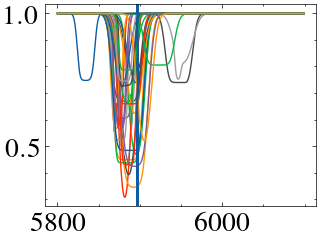

In [410]:
EW=[]
#spix=((lam[goodpixind]>6050) &(lam[goodpixind]<6100))
tbin=0
for i,q in enumerate(qlist):
    ncomp=q.abs_ncomp
    
    """
    nabs=q.num_abs_line
    ind_ini_Naemit=np.where(q.gauss_result_name=="NaI5896emit_1_scale")[0][0]
    
    ind_ini=np.where(q.gauss_result_name=="HeI5876_1_scale")[0][0]
    param=q.gauss_result[ind_ini:ind_ini+3]
        
    
    f_lam=q.Manygauss(np.log(q.wave), q.gauss_result)+q.external_cont
    cont=q.external_cont[spix]+q.Onegauss(np.log(q.wave),param)[spix]
    #line_area=np.trapz(f_lam[spix],x=q.wave[spix])
    #cont_area=np.trapz(q.external_cont[spix]+q.Onegauss(np.log(q.wave),param)[spix],x=q.wave[spix])
    EW.append(np.trapz(1-f_lam[spix]/cont,x=q.wave[spix]))
    if EW[-1]<0:
        plt.plot(q.wave[spix],f_lam[spix],color="k")
        plt.plot(q.wave[spix],q.external_cont[spix]+q.Onegauss(np.log(q.wave),param)[spix],color="b")
        plt.axvline(5897)
    """
    spix=((q.wave>5800) &(q.wave<6100))
    ngauss = len(q.gauss_result[:-ncomp]) // 3
    pp_shaped=np.reshape(q.gauss_result[:-ncomp], (ngauss, 3))
    pp_shaped_abs = pp_shaped[:ncomp,:]
    Cfs=q.gauss_result[-ncomp:]
    EW.append(np.trapz(1-q._Manygauss_abs_2(np.log(q.wave), pp_shaped_abs,Cfs),x=q.wave))
    if EW[-1]>5:
    #plt.plot(q.wave[spix],f_lam[spix],color="k")
    #plt.plot(q.wave[spix],q.external_cont[spix]+q.Onegauss(np.log(q.wave),param)[spix]*,color="b")
        plt.plot(q.wave[spix],q._Manygauss_abs_2(np.log(q.wave[spix]), pp_shaped_abs,Cfs))
        plt.axvline(5897)
    


(6862,)

In [714]:
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

W80=np.full(len(qlist), np.nan)
lname="Hb_na"
spix=((lam[goodpixind]>4500) &(lam[goodpixind]<5100))
for i,q in enumerate(qlist):
    ind_ini1=np.where(q.gauss_result_name=="{}_1_scale".format(lname))[0][0]
    param1=q.gauss_result[ind_ini1:ind_ini1+3]
    x=np.log(q.wave)
    if "{}w_1_scale".format(lname) in q.gauss_result_name:
        ind_ini2=np.where(q.gauss_result_name=="{}w_1_scale".format(lname))[0][0]
        param2=q.gauss_result[ind_ini2:ind_ini2+3]
        f_lam=q.Onegauss(x,param1)+q.Onegauss(x,param2)
    else:
        ind_ini2=np.nan
        param2=np.array([])
        f_lam=q.Onegauss(x,param1)
    
    cumulative_area = cumtrapz(f_lam[spix], x[spix], initial=0)
    cumulative_area /= cumulative_area[-1]  # Normalize to go from 0 to 1

    # Use interpolation to estimate the percentiles at 10% and 90%
    interp_func = interp1d(cumulative_area, x[spix])
    x10 = interp_func(0.1)
    x90 = interp_func(0.9)
    W80[i]=(x90-x10)*3e5 ## W80 line width
    #plt.plot(q.wave,f_lam,color="k")
    #plt.plot(q.wave,q.external_cont+q.Onegauss(np.log(q.wave),param),color="b")
    #plt.axvline(5897)
    


## Read line properties into dictionary

In [402]:
ckm = constants.c.to(u.km/u.s).value  # speed of light in km/s

linesoi=["NaI5890","NaI5896"]
abslines=["NaI5890","NaI5896","NaI5890w","NaI5896w"]
#linesoi=["NaI5896"]
#line=linesoi[1:]
snrcut=1
for line in linesoi:
    fwhmlist=[]
    arealist=[]
    vpeclist=[]

    bvpeclist=[]
    bfwhmlist=[]
    snrlist=[]
    
    taulist=[]
    bsigmalist=[]
    barealist=[]
    bexistlist=[]
    Cf=[]
    for i,q in enumerate(qlist):#enumerate([qlist[165]]):#
        nabs=q.num_abs_line
        taus=q.gauss_result[:3*nabs:3]
        awave=np.exp(q.gauss_result[1:3*nabs:3])
        asigma=np.array(q.gauss_result[2:3*nabs:3]*ckm)
        select=line_list['linename']==line
        line_lam=line_list["lambda"][select][0]
        #if i==0:
         #   line_properties[line]=[]
        
        if line in abslines:
            lfwhm=np.nan
            bfwhm=np.nan
            blinec=np.nan
            absind=np.where(np.array(abslines)==line)[0][0]
            peak=awave[absind]
            sigma=asigma[absind]
            tau=taus[absind]
            if nabs>2:
                wpeak=awave[absind+2] # this is a doublet
                wsigma=asigma[absind+2]
                wtau=taus[absind+2]
                if wtau>tau:
                    atau=wtau
                    Cfnow=q.gauss_result[-1]
                    linec=wpeak
                    bsigma=wsigma
                else:
                    Cfnow=q.gauss_result[-2] ## two velocity components, with Cfnow being the C_f of the component with highest tau
                    atau=tau
                    linec=peak
                    bsigma=sigma
            else:
                atau=tau
                Cfnow=q.gauss_result[-1]
                linec=peak
                bsigma=sigma
                #print(Cfnow)
            
        else:
            Cfnow=np.nan
            atau=np.nan
            bsigma=np.nan
            try:
                wfwhm, wsigma, wew, wpeak, warea, wsnr = q.line_prop_from_name(f'{line:s}w', 'narrow')
            except:
                print("warning: unsuccessful line fit for wind component")
                wsnr=0.
        
            if line == "OIII5007":
                try:
                    fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(f'{line:s}c', 'narrow')
                except:
                    print("warning: unsuccessful line fit for core component")
                    snr=0.
            else:
                try:
                    fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(f'{line:s}', 'narrow')
                except:
                    print("warning: unsuccessful line fit for core component")
                    snr=0.
            if wsnr<snrcut and snr>snrcut:
                linec=peak
                blinec=peak
                lfwhm=fwhm
                bfwhm=fwhm
                ssnr=snr
            elif wsnr>snrcut and snr<snrcut:
                linec=wpeak
                blinec=wpeak
                lfwhm=wfwhm
                bfwhm=wfwhm
                ssnr=wsnr
            elif wsnr>snrcut and snr>snrcut:
                fwhms=np.array([fwhm,wfwhm])
                linecs=np.array([peak,wpeak])
                areas=np.array([area,warea])
                linec=(area*peak+warea*wpeak)/(area+warea)
                lfwhm=(area*fwhm+warea*wfwhm)/(area+warea)
                mind=np.argmax(fwhms)
                bfwhm=fwhms[mind]
                blinec=linecs[mind]
                barea=areas[mind]
                ssnr=np.max([wsnr,snr])
            else:
                print("warning, all nan")
                linec=np.nan
                lfwhm=np.nan
                bfwhm=np.nan
                blinec=np.nan
                area=np.nan
                warea=np.nan
                barea=np.nan
                ssnr=0.
        znew = linec/line_lam-1
        bznew = blinec/line_lam-1
        #vpec = np.log((1+znew))*c
        vpec=znew*ckm
        #bvpec = np.log((1+bznew))*c
        bvpec = bznew*ckm
        #vpec = znew*c
        vpeclist.append(vpec)
        bvpeclist.append(bvpec)
        snrlist.append(ssnr)
        arealist.append(warea+area)
        fwhmlist.append(lfwhm)
        bfwhmlist.append(bfwhm)
        bexist=False
        if bfwhm>500:
            bexist=True
        bexistlist.append(bexist)
        bsigmalist.append(bsigma)
        barealist.append(barea)
        taulist.append(atau)
        Cf.append(Cfnow)
    #line_properties[line].append([[linec,vpec],[fwhm,sigma,ew,peak,area,snr],[wfwhm, wsigma, wew, wpeak, warea, wsnr]])
    line_properties[line+"_vpec"]=vpeclist.copy()
    line_properties[line+"_broad_vpec"]=bvpeclist.copy()
    line_properties[line+"_broad_fwhm"]=bfwhmlist.copy()
    line_properties[line+"_snr"]=snrlist.copy()
    line_properties[line+"_fwhm"]=fwhmlist.copy()
    line_properties[line+"_area"]=arealist.copy()
    line_properties[line+"_broad_area"]=barealist.copy()
    line_properties[line+"_tau"]=taulist.copy()
    line_properties[line+"_broad_exist"]=bexistlist.copy()
    line_properties[line+"_deep_sigma"]=bsigmalist.copy()
line_properties["Cf"]=Cf.copy()


## Test one bin

In [341]:
area

0.06758620619315737

Text(0, 0.5, '$\\rm f_{\\lambda}$ ($\\rm 10^{-17} erg\\;s^{-1}\\;cm^{-2}\\;\\AA^{-1}$)')

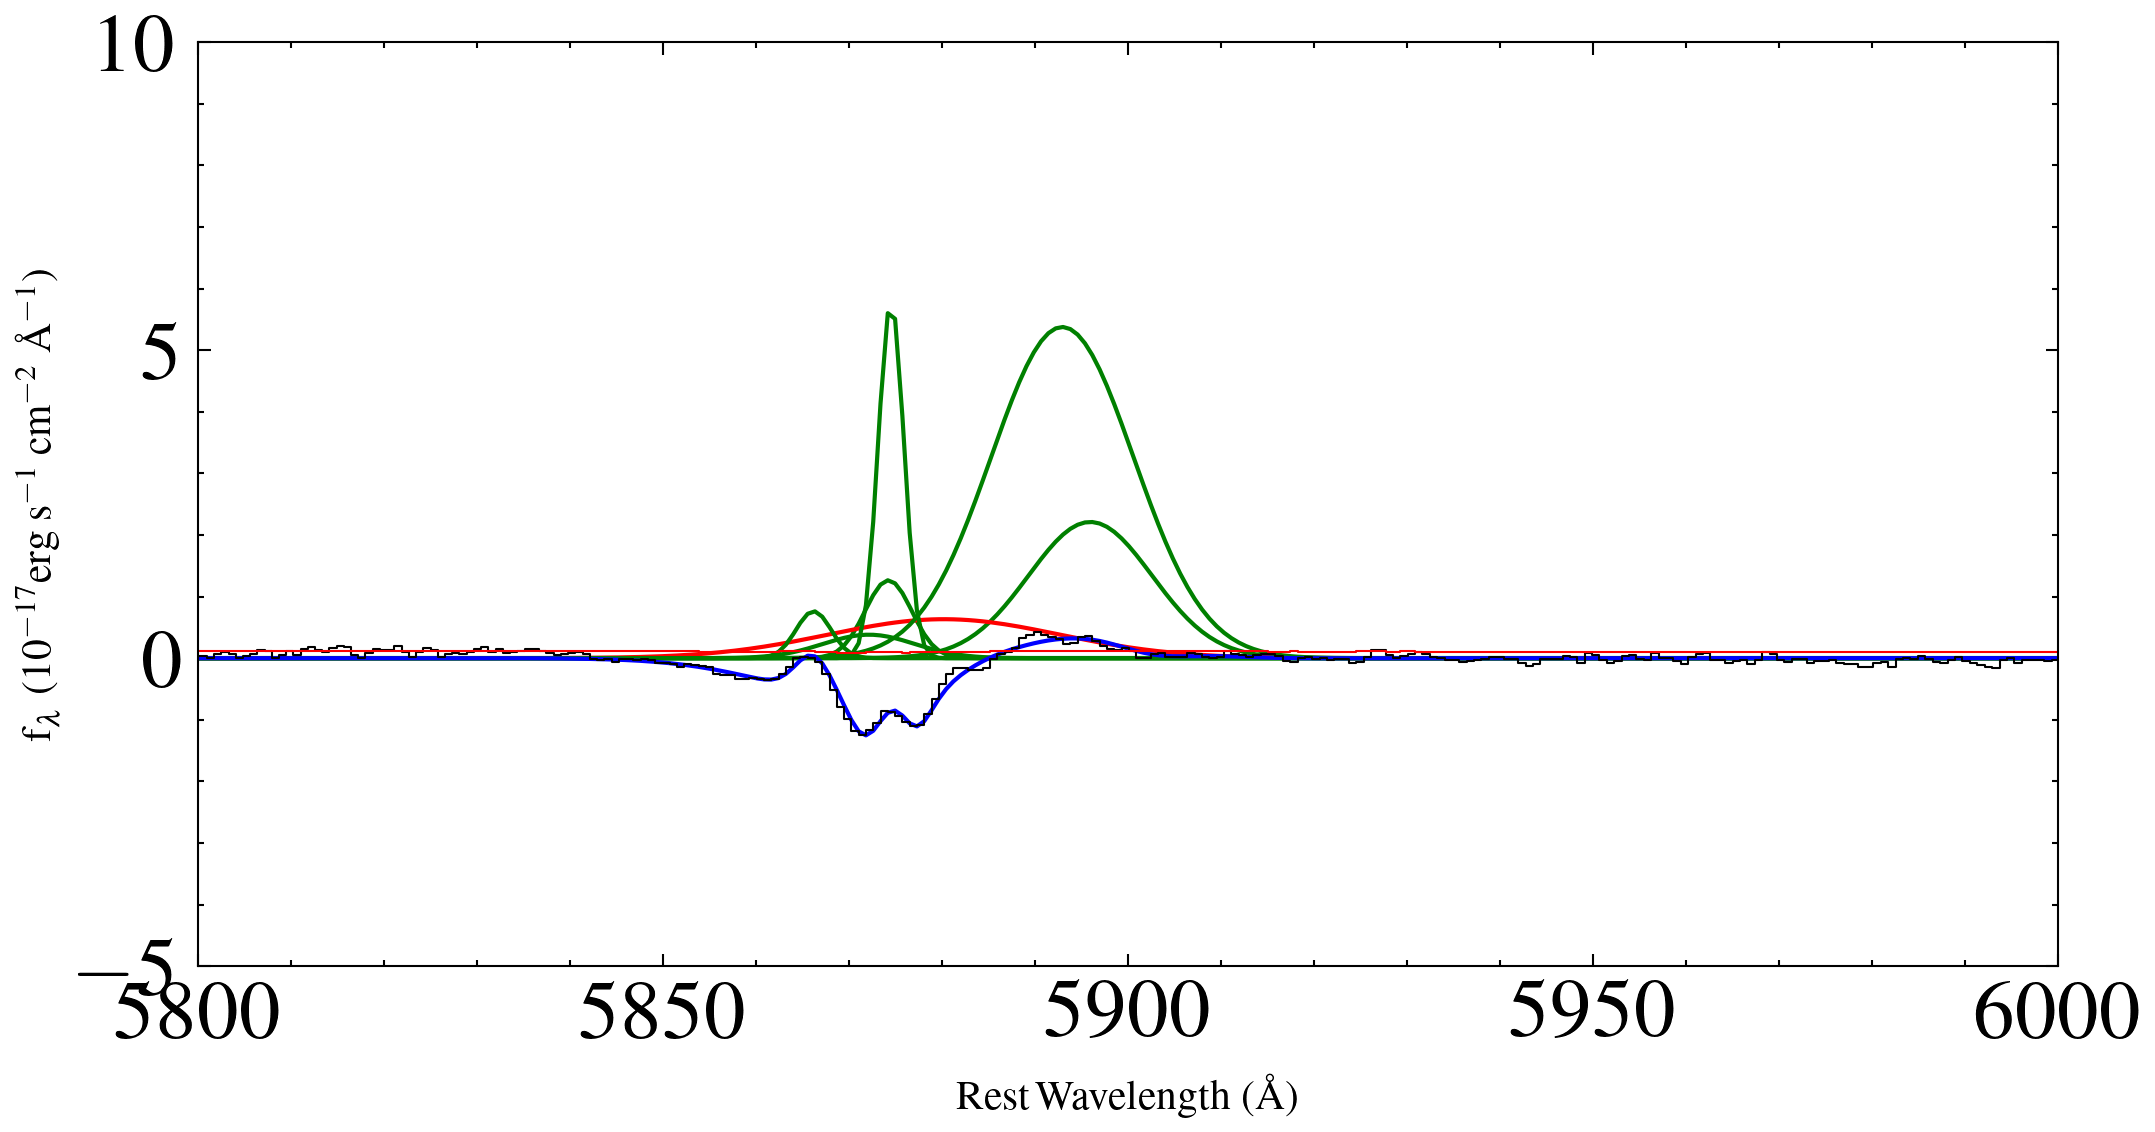

In [403]:
tbin=4
q=qlist[tbin]
#q=q_temp
# increase the cut-off voronoi S/N?
# center region is having too low S/N

fig, ax = plt.subplots(1, 1,figsize=(8,4), dpi=300)
plt.subplots_adjust(wspace=0.5)
#q=q_mle

#q.set_mpl_style( tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0)
#fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name("HeI5876", 'narrow')
#ax.axvline(peak,color="red",lw=0.5,ls=":")
if q.MCMC:
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result
#plt.subplot(111)
ax=ax
# Plot individual line components
for p in range(int(len(gauss_result) / 3)):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

# Plot total line model
ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
ax.step(q.wave, q.line_flux, 'k',lw=0.5)
ax.step(q.wave, q.err, 'r',lw=0.5)

ln_to_print=['OIII5007c','OIII4959c',"NII6549","NII6585","SII6718","SII6732",'Ha_na','Hb_na',"HeI5876","NaI5890","NaI5896"]
text=[r'[OIII]$\,$5007',r'[OIII]$\,$4959',r"[NII]$\,$6549",r"[NII]$\,$6585",r"[SII]$\,$6718",r"[SII]$\,$6732"]
xlow=5800
xhigh=6000
"""
for ind,ln in enumerate(ln_to_print):
    if "br" in ln:
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(ln, 'broad')
    else:
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(ln, 'narrow')
    #all_area[ln]=area
    #all_peaks[ln]=peak
    print("{}:".format(ln))
    print("FWHM (km/s)", np.round(fwhm, 1))
    print("Sigma (km/s)", np.round(sigma, 1))
    print("EW (A)", np.round(ew, 1))
    print("Peak (A)", np.round(peak, 1))
    print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
    print("")
    if peak > xhigh or peak < xlow:
        continue
    ax.axvline(peak,color="C{}".format(ind),lw=0.5,ls=":")
    try:
        ax.text(peak*0.999, 5e-1*yup,text[ind], rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=8)
    except:
        print(ln,"doesn't have a text label!")
"""
#ax.step(q.wave,q.err)
ax.set_xlim(xlow, xhigh)
ax.set_ylim(-5, 10)
#ax.set_yscale("log")
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize=10)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize=10)

In [411]:


result      = np.zeros((len(ubins),7))
#result[:,0] = np.array( line_properties["Ha_na_vpec"] )
#result[:,1] = np.array( line_properties["Ha_na_fwhm"])
#result[:,2] = np.array( line_properties["OIII5007_vpec"]    )
#result[:,3] = np.array( line_properties["OIII5007_fwhm"])
#result[:,0] = np.array( line_properties["NII6585_vpec"])
#####======================= line kinematics==================##
"""
result[:,0] = np.array( line_properties["Ha_na_broad_vpec"] )
result[:,1] = np.array( line_properties["Ha_na_broad_fwhm"])
result[:,2] = np.array( line_properties["OIII5007_broad_vpec"] )
result[:,3] = np.array( line_properties["OIII5007_broad_fwhm"])
result[:,4] = np.array( np.array(line_properties["Ha_na_area"])/np.array(line_properties["Hb_na_area"]))
result[:,5] = np.array( line_properties["OIII5007_area"])
"""
# =============== absorption line kinematics =================##
result[:,0] = np.array( line_properties["NaI5896_tau"])
result[:,1] = np.array( line_properties["NaI5896_deep_sigma"])
result[:,2] = np.array( line_properties["NaI5896_vpec"])
result[:,3] = np.array( line_properties["Cf"])
result[:,4] = np.array( EW.copy())
"""

#================ electron density and ionized gas outflow=========##
result[:,0] = np.array( line_properties["SII6718_area"])
result[:,1] = np.array( line_properties["SII6732_area"])
result[:,2] = np.array( line_properties["Hb_na_broad_vpec"])-np.array( line_properties["Hb_na_vpec"])
result[:,3] = np.array( line_properties["Hb_na_broad_vpec"])#line_properties["SII6732_broad_area"])
result[:,4] = np.array( np.array(line_properties["Ha_na_area"])/np.array(line_properties["Hb_na_area"]))
result[:,5] = np.array( line_properties["Hb_na_broad_area"])
result[:,6] = np.array( line_properties["Hb_na_broad_fwhm"])
#result[:,3] = np.array( line_properties["NaI5890w_tau"])
#result[:,4] = np.array( line_properties["NaI5890w_deep_sigma"])
# =============== construct BPT map=====================#

result[:,0] = np.array(line_properties["NII6585_area"])
result[:,1] = np.array(line_properties["OIII5007_area"])
result[:,2] = np.array(line_properties["Ha_na_area"])
result[:,3] = np.array(line_properties["Hb_na_area"])
result[:,4] =  np.array(line_properties["SII6718_area"])+np.array(line_properties["SII6732_area"])
result[:,5] = np.array(line_properties["NII6585_broad_fwhm"])

#EBV=2.5/1.163*np.log10(((all_area['Ha_naw']+all_area['Ha_na'])/(all_area['Hb_naw']+all_area['Hb_na'])/2.68))
"""

result_long  = np.zeros( (len(binNum_long), result.shape[1]) ); result_long[:,:] = np.nan
surface_density=False
for ii in range( len(ubins) ):
    idx = np.where( ubins[ii] == binNum_long )[0]
    result_long[idx,:]  = result[ii,:]
    #Nbins=len(idx)
    if surface_density:
        result_long[idx,5]/=(len(idx)*pixelsize**2)
result = result_long
#result[:,0] = result[:,0] - np.nanmedian( result[:,0] )


padding=0.0
xmin = np.nanmin(X)-padding;  xmax = np.nanmax(X)+padding
ymin = np.nanmin(Y)-padding;  ymax = np.nanmax(Y)+padding
npixels_x = int( np.round( (xmax - xmin)/pixelsize ) + 1 )
npixels_y = int( np.round( (ymax - ymin)/pixelsize ) + 1 )
i = np.array( np.round( (X - xmin)/pixelsize ), dtype=int )
j = np.array( np.round( (Y - ymin)/pixelsize ), dtype=int )


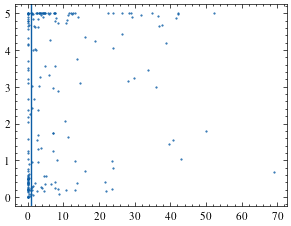

In [578]:
plt.errorbar(EW,line_properties["NaI5896_tau"],fmt="o",ms=0.5)
plt.axvline(1)

## NaID K absorption

ValueError: Maximum allowed size exceeded

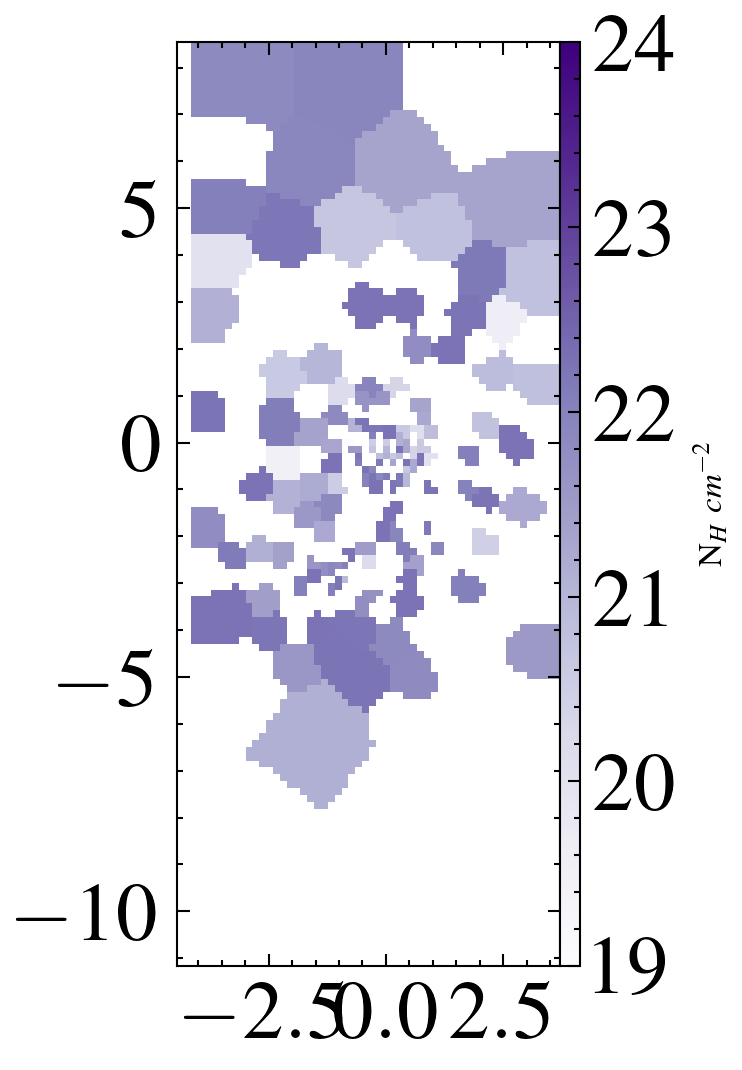

In [412]:
from astropy.stats import sigma_clipped_stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,0]*500/1.497e-15/0.318/5879.55
refim = np.full( (npixels_x, npixels_y), np.nan )
refim[i,j] = result[:,3]
EWrefim = np.full( (npixels_x, npixels_y), np.nan )
EWrefim[i,j] = result[:,4]
image=np.where((refim>0.01)&(EWrefim>0.1), image, np.nan)
y=0.9
a=-5.347
b=-0.95
NH=image/(1-y)*10**(-a-b)
fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=19
vmax=24
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(np.log10(NH)), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"N$_{H}$ $cm^{-2}$")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
#line=r"[OIII]"
line=r"NaID"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
#fig.savefig(datapath+"/fig/{}_NH_map.pdf".format(line))

In [535]:
np.nanmax(NH)

1.7698929541451591e+22

Text(0.05, 0.9, 'NaID map')

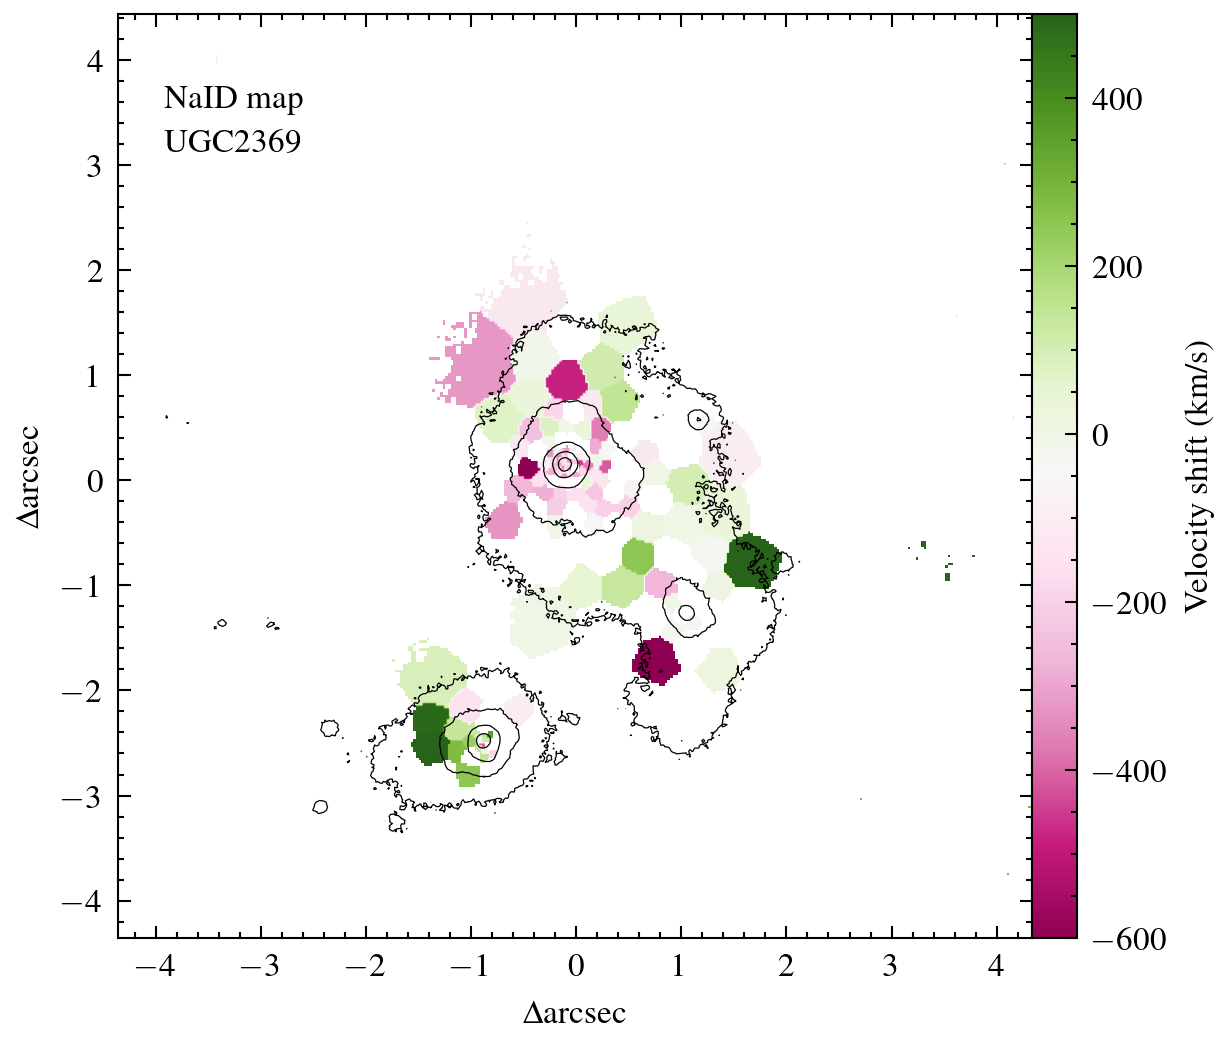

In [566]:
from astropy.stats import sigma_clipped_stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,2]#-np.nanmedian(result[:,2])

refim = np.full( (npixels_x, npixels_y), np.nan )
refim[i,j] = result[:,3]

vshift=np.where((refim>0.1)&(EWrefim>0.1), image, np.nan)


fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=-600
#vmin=0
vmax=500
cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(vshift), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"Velocity shift (km/s)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
#line=r"[OIII]"
line=r"NaID"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
#fig.savefig(datapath+"/fig/{}_vshift_broad_map.pdf".format(line))

## generate outflow mass rate from Cf, NH and v_out

Text(0.05, 0.9, 'NaID map')

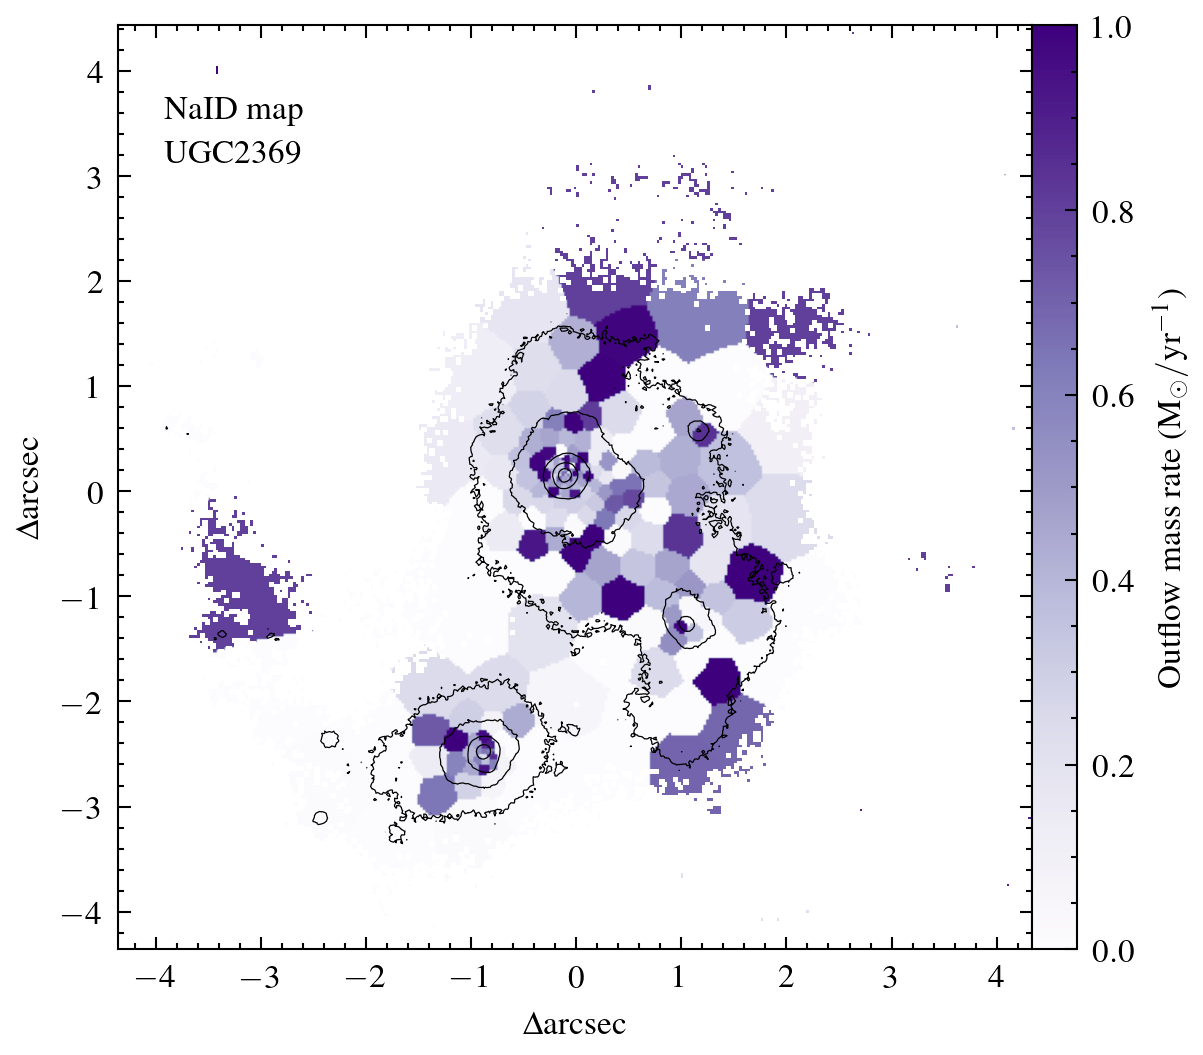

In [571]:

from astropy.stats import sigma_clipped_stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

#mdot=11.5*0.8/0.4*refim*(0.4/10)*NH/1e21*np.abs(vshift)/200 #Equation (14) of Rupke 2005 ApJS 160 115

mdot=np.where((refim>0.1)&(EWrefim>0.5), mdot, np.nan)

fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=0
vmax=1
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(refim), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"Outflow mass rate (M$_{\odot}/\rm yr^{-1}$)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
#line=r"[OIII]"
line=r"NaID"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
#fig.savefig(datapath+"/fig/{}_vshift_broad_map.pdf".format(line))

In [443]:
from astropy.cosmology import Planck18
Planck18.kpc_proper_per_arcmin(0.0312)/60

<Quantity 0.64518203 kpc / arcmin>

In [445]:
Planck18.luminosity_distance(0.032)

<Quantity 145.22544591 Mpc>

Text(0.05, 0.9, 'NaID map')

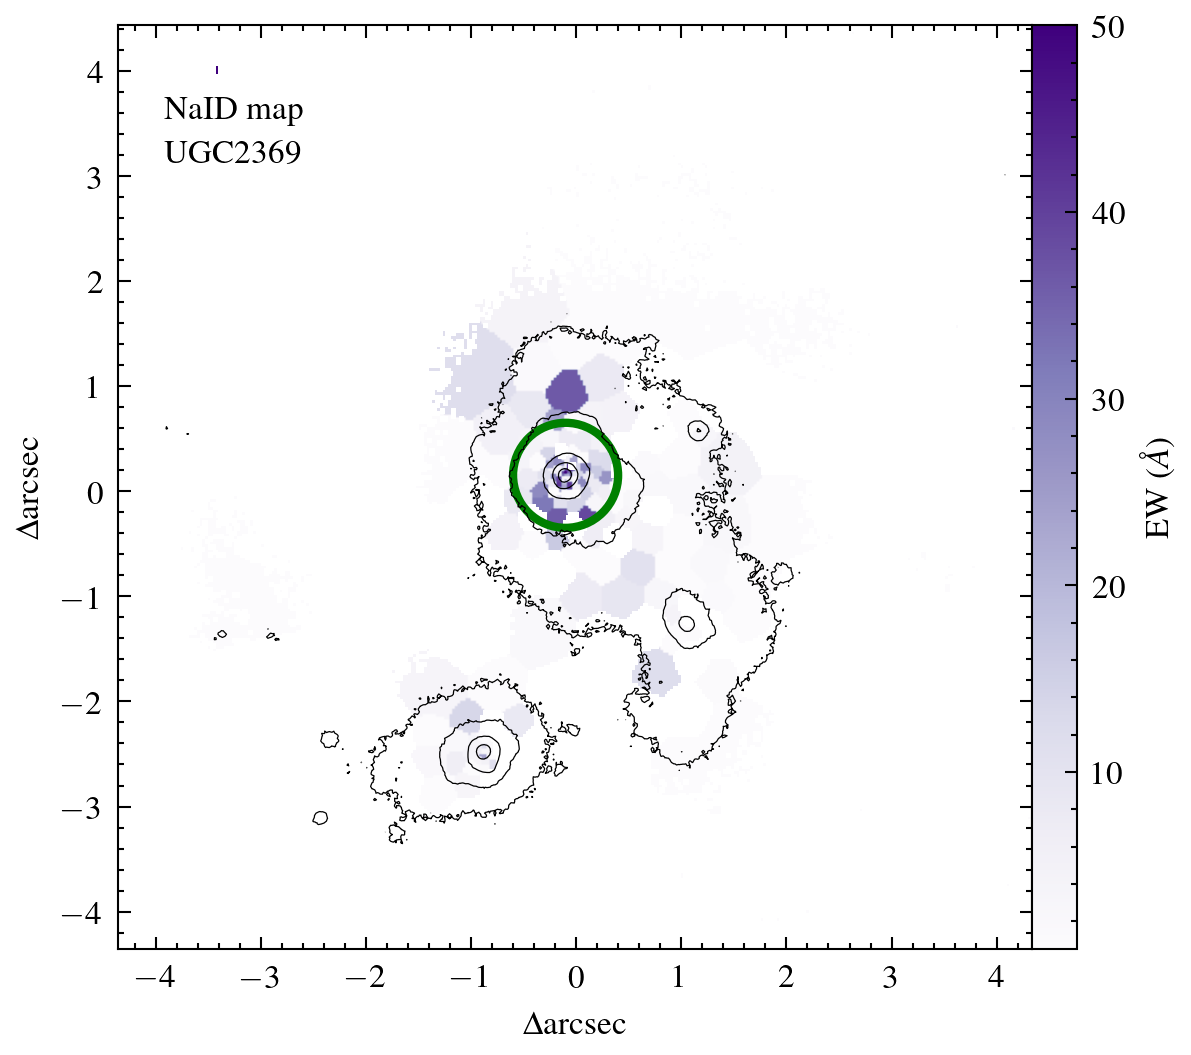

In [603]:
from astropy.stats import sigma_clipped_stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,4]#/0.758*0.32/0.4164*5897/1215*10/500*1e13
refim = np.full( (npixels_x, npixels_y), np.nan )
refim[i,j] = result[:,3]

image=np.where((refim>0.1), image, np.nan)
EBVneutral=-0.02+0.29*image
fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=0.5
vmax=50
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(image), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"EW ($\AA$)")

circle = plt.Circle((-0.1025,0.1525), 0.5, color='green', fill=False, linewidth=2)
ax.add_patch(circle)


XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
#line=r"[OIII]"
line=r"NaID"

ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
#fig.savefig(datapath+"/fig/{}_vshift_broad_map.pdf".format(line))

## Ionized gas mass and outflow rate

In [664]:
from scipy.interpolate import interp1d
SII2netab=np.genfromtxt(multiAGNpath+"/Osterbrock2006_SII2ne.csv")
SII2ne=interp1d(SII2netab[:,1],SII2netab[:,0],fill_value=np.nan,bounds_error=False)


In [901]:

ne = np.full( (npixels_x, npixels_y), np.nan )
ne[i,j] = SII2ne(result[:,0]/result[:,1])

Text(0.05, 0.9, 'Electron density map')

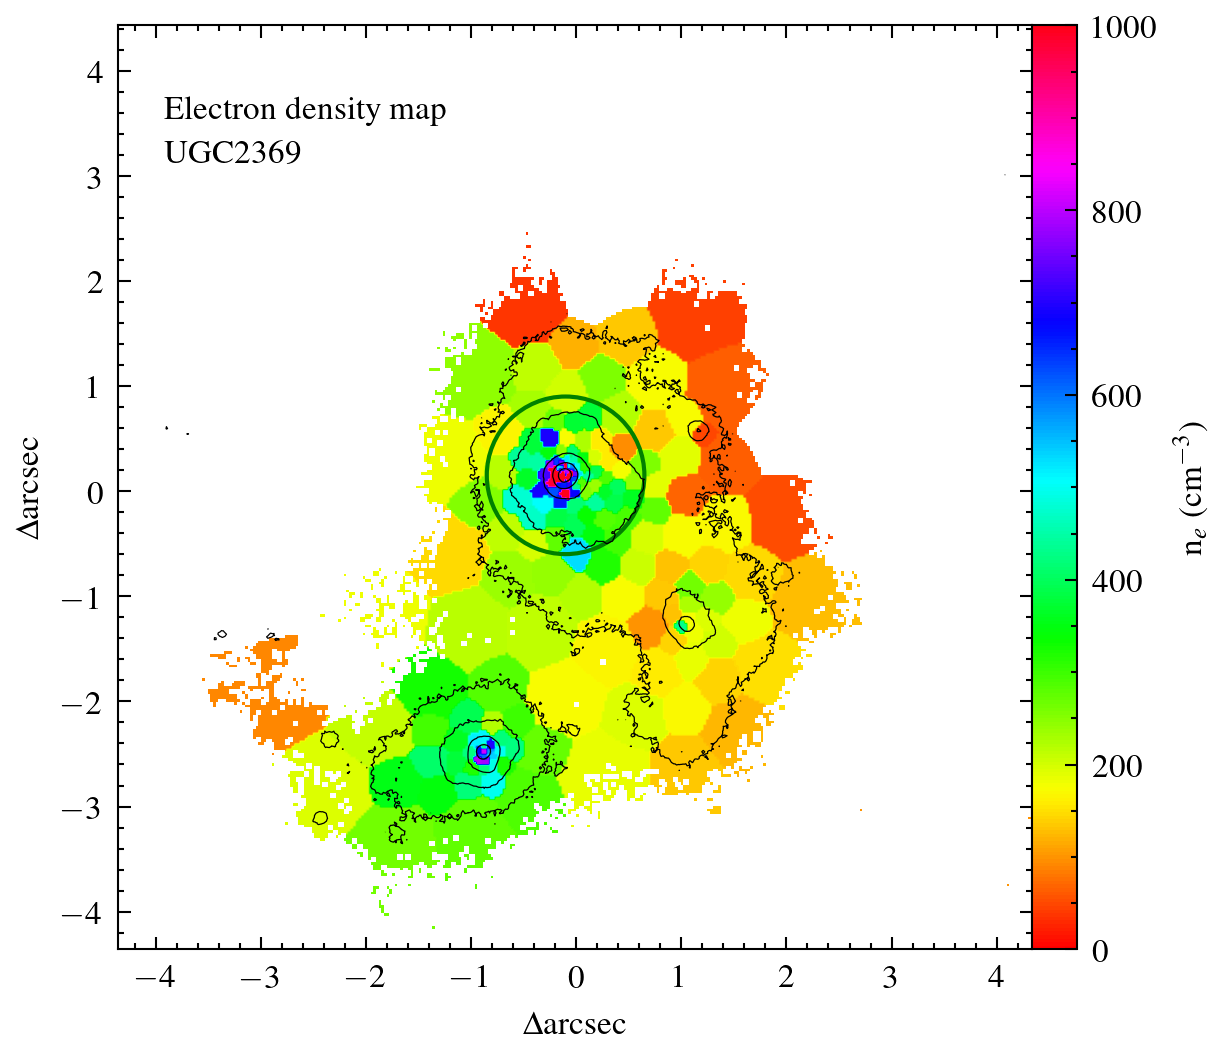

In [903]:
from astropy.stats import sigma_clipped_stats


#image = np.full( (npixels_x, npixels_y), np.nan )
#image[i,j] = result[:,3]

#image=np.where(refim, image, np.nan)
fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=np.log10(image)
vmin=0
vmax=1000
cmap = plt.cm.hsv
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(ne), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"n$_{e}$ ($\rm cm^{-3}$)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

circle = plt.Circle((-0.1025,0.1525), 0.75, color='green', fill=False, linewidth=1)
ax.add_patch(circle)

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"Electron density"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
#fig.savefig(datapath+"/fig/{}_vdisp_broad_map.pdf".format(line))

In [781]:
np.nanmean(LHb*10**(0.4*Cex.k_lambda(x=[0.4861])*EBV))

7.5150792662146e+39

Text(0.05, 0.9, 'Ionized gas mass map')

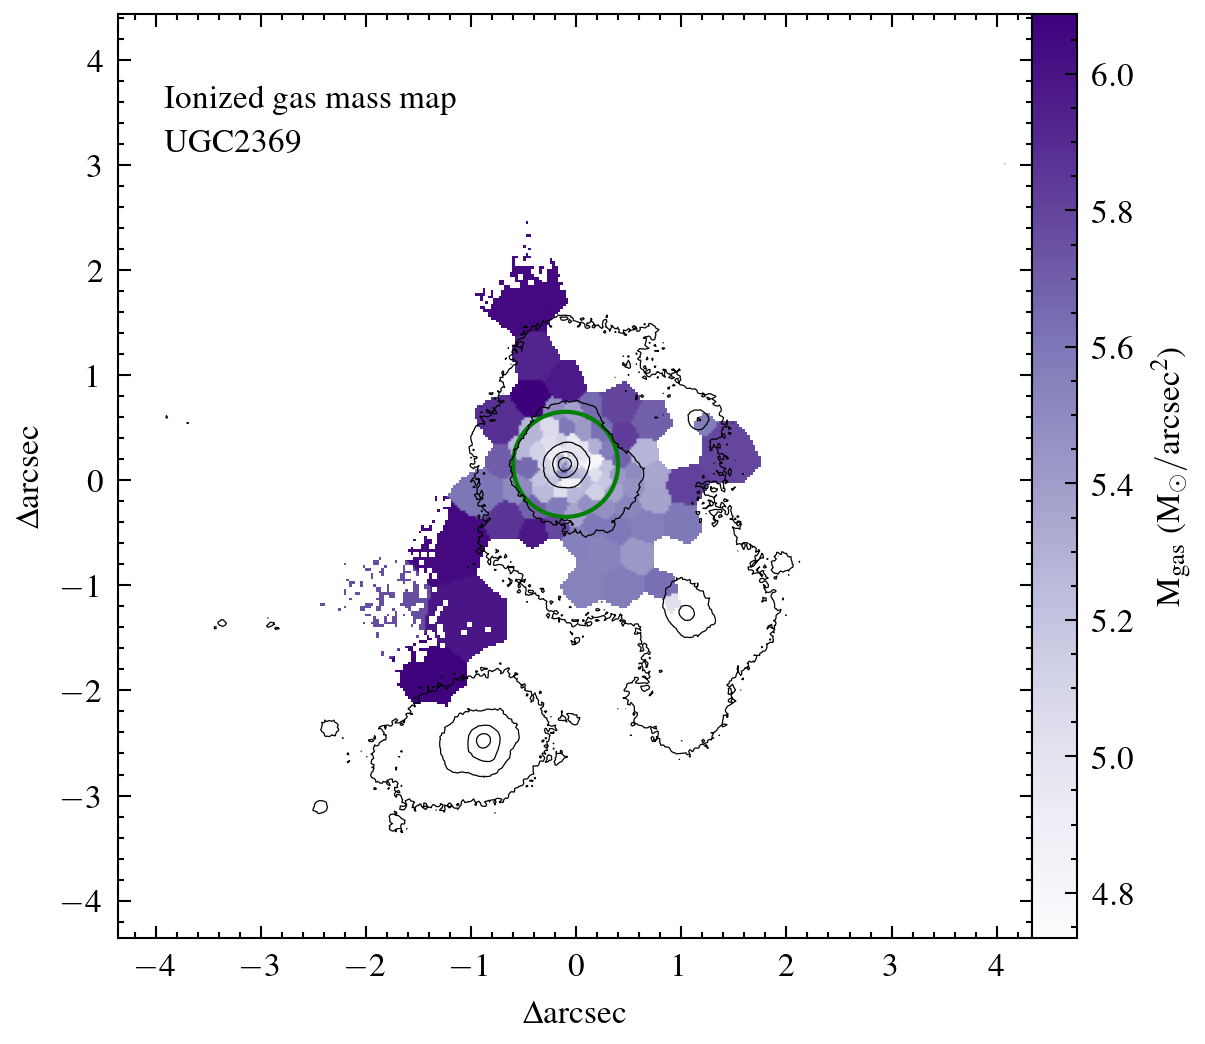

In [909]:
from astropy.stats import sigma_clipped_stats


LHb = np.full( (npixels_x, npixels_y), np.nan )
Hbfwhm = np.full( (npixels_x, npixels_y), np.nan )

Sld=Planck18.luminosity_distance(z=0.03145).to(u.cm).value**2*4*np.pi
LHb[i,j] = Sld*result[:,5]*1e-20
Hbfwhm[i,j]=result[:,6]


Miongas=LHb*10**(0.4*Cex.k_lambda(x=[0.4861])*EBV)/1e43*2.82e9*1/(ne/100) ##ionized gas mass, Liu+2013 equation (14) 
Miongas=np.where((Hbfwhm>500), Miongas, np.nan)
fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=np.log10(image)
vmin=0
vmax=400
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(np.log10(Miongas)), cmap=cmap, interpolation=None,# vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"M$_\mathrm{gas}$ ($\rm M_{\odot}/arcsec^{2}$)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()
circle = plt.Circle((-0.1025,0.1525), 0.5, color='green', fill=False, linewidth=1)
ax.add_patch(circle)

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"Ionized gas mass"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
#fig.savefig(datapath+"/fig/{}_vdisp_broad_map.pdf".format(line))

In [838]:
print("%.2e"%np.nansum(Miongas*np.abs(vout*u.km.to(u.cm))**2*0.5*u.M_sun.to(u.g)))

5.89e+56


In [864]:
3*np.nansum(LHb*u.u.to(u.g)/ne/constants.h.to(u.erg*u.s).value/ccgs/1.17e-13*(4861*u.AA.to(u.cm)))/(0.5*u.kpc.to(u.cm))

6.985026771553794e+20

In [862]:
np.nanmedian(1/ne/constants.h.to(u.erg*u.s).value/1.17e-13/(4861*u.AA.to(u.cm)))

1.4362358486302033e+41

In [973]:
kpc_per_pix*30

0.4920158139748433

total outflow mass (Msun/yr): 976.1430885289813
total outflow energy (erg/s): 8.748552463465904e+43


Text(0.05, 0.9, 'Outflow rate map')

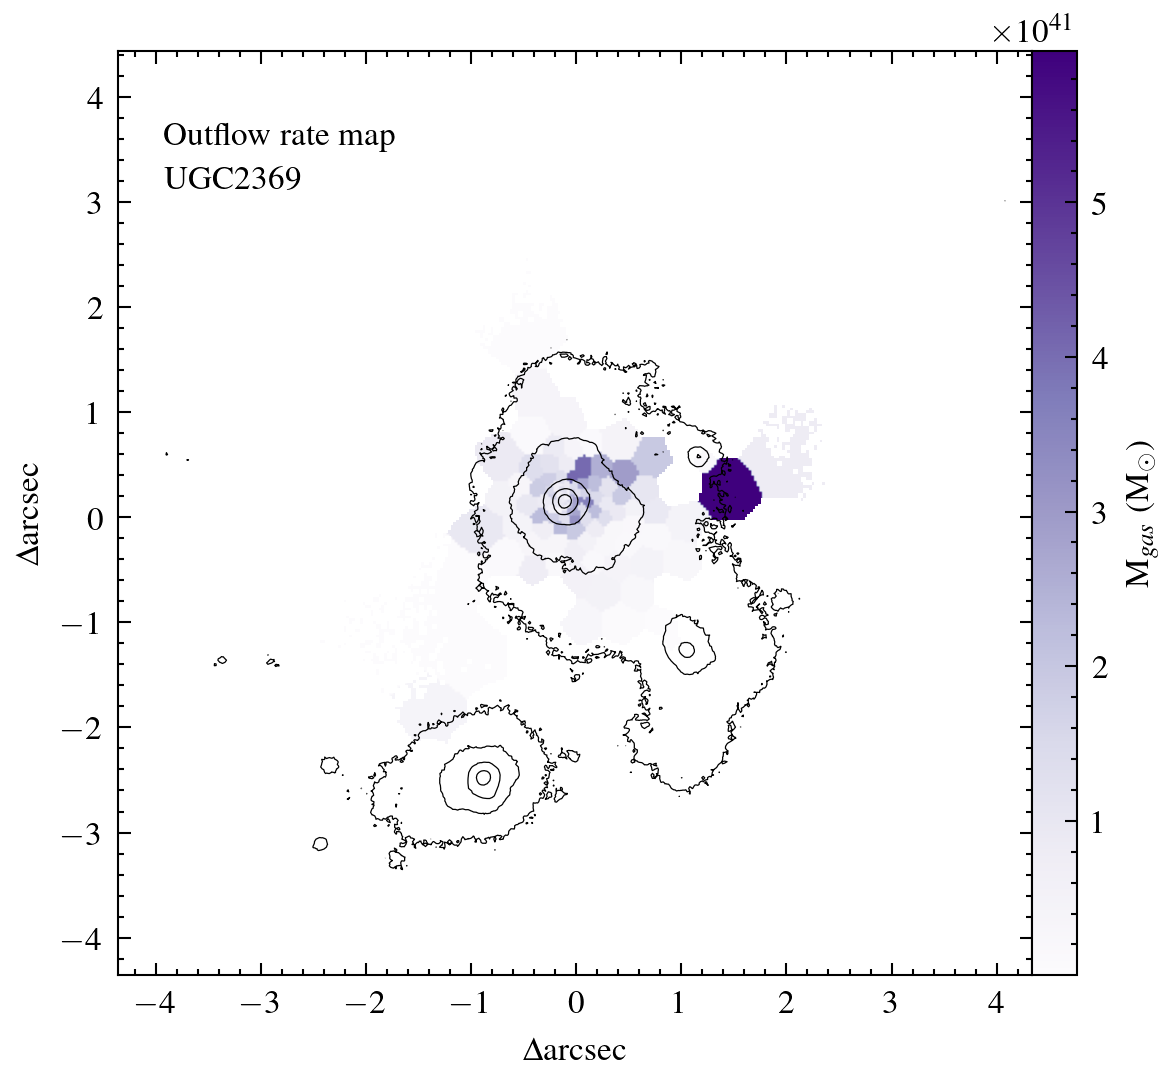

In [924]:
from astropy.stats import sigma_clipped_stats

sigmaHb = np.full( (npixels_x, npixels_y), np.nan )
sigmaHb[i,j] = result[:,5]*1e-20
sigmaHb *= 10**(0.4*Cex.k_lambda(x=[0.4861])*EBV)


vout = np.full( (npixels_x, npixels_y), np.nan )
vout[i,j]=result[:,3]
Rout=0.75*Planck18.kpc_proper_per_arcmin(0.0312).value/60
Mdot1=Miongas*np.abs(vout)/(Rout*u.kpc.to(u.km))/u.s.to(u.yr)#0.5*Miongas*u.M_sun.to(u.g)*(image*u.km.to(u.cm))**2
Edot2=1.5e46*(Rout/10)**2*np.abs(vout/1000)**3*1
Mdot2=2*Edot2/(np.abs(vout*u.km.to(u.cm))**2)*u.g.to(u.M_sun)/u.s.to(u.yr)
Edot1=Mdot1*u.M_sun.to(u.g)/u.yr.to(u.s)/2*(np.abs(vout*u.km.to(u.cm))**2+3*(Hbfwhm*u.km.to(u.cm)/2.355)**2)
#sigmaHb/5e-15*Rout/7*np.abs(vout)/760*1/(ne/10)*2240
#Mdot=0.5*Miongas*np.abs(vout)**2/c**2

#Mdot=1.5e46*(Rout/10)**2*np.abs(vout/1000)**3*1/(np.abs(vout)*u.km.to(u.cm))**2*u.g.to(u.M_sun)/u.s.to(u.yr)

Mdot2=np.where(Hbfwhm>500, Mdot2, np.nan)
Edot2=np.where(Hbfwhm>500, Edot2, np.nan)

print("total outflow mass (Msun/yr):",np.nansum(Mdot))
print("total outflow energy (erg/s):",np.nansum(Edot))

fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=np.log10(image)
vmin=0
vmax=10
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(Edot2), cmap=cmap, interpolation=None,# vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"M$_{gas}$ ($\rm M_{\odot}$)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"Outflow rate"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
#fig.savefig(datapath+"/fig/{}_vdisp_broad_map.pdf".format(line))

In [840]:
(Rout*u.kpc.to(u.km))

4977059293605432.0

## other various maps

Text(0.05, 0.9, 'H$\\beta$ map')

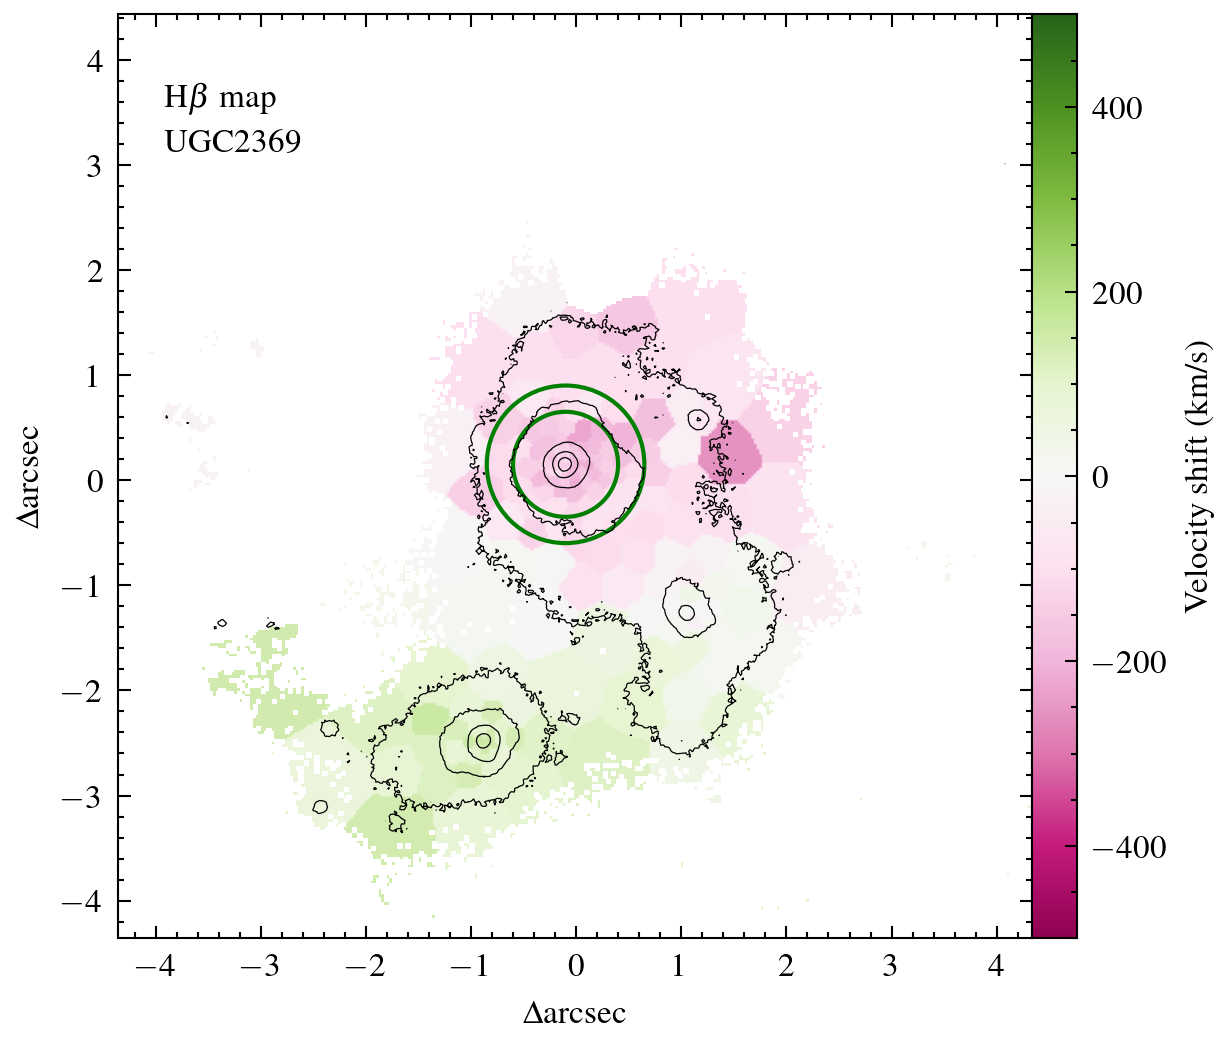

In [920]:
from astropy.stats import sigma_clipped_stats


image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,3]

#image=np.where(refim, image, np.nan)
fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=p.log10(image)
vmin=-500
vmax=500
cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(image), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"Velocity shift (km/s)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

circle1 = plt.Circle((-0.1025,0.1525), 0.75, color='green', fill=False, linewidth=1)
circle2 = plt.Circle((-0.1025,0.1525), 0.5, color='green', fill=False, linewidth=1)
ax.add_patch(circle1)
ax.add_patch(circle2)

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"H$\beta$"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
#fig.savefig(datapath+"/fig/{}_vdisp_broad_map.pdf".format(line))

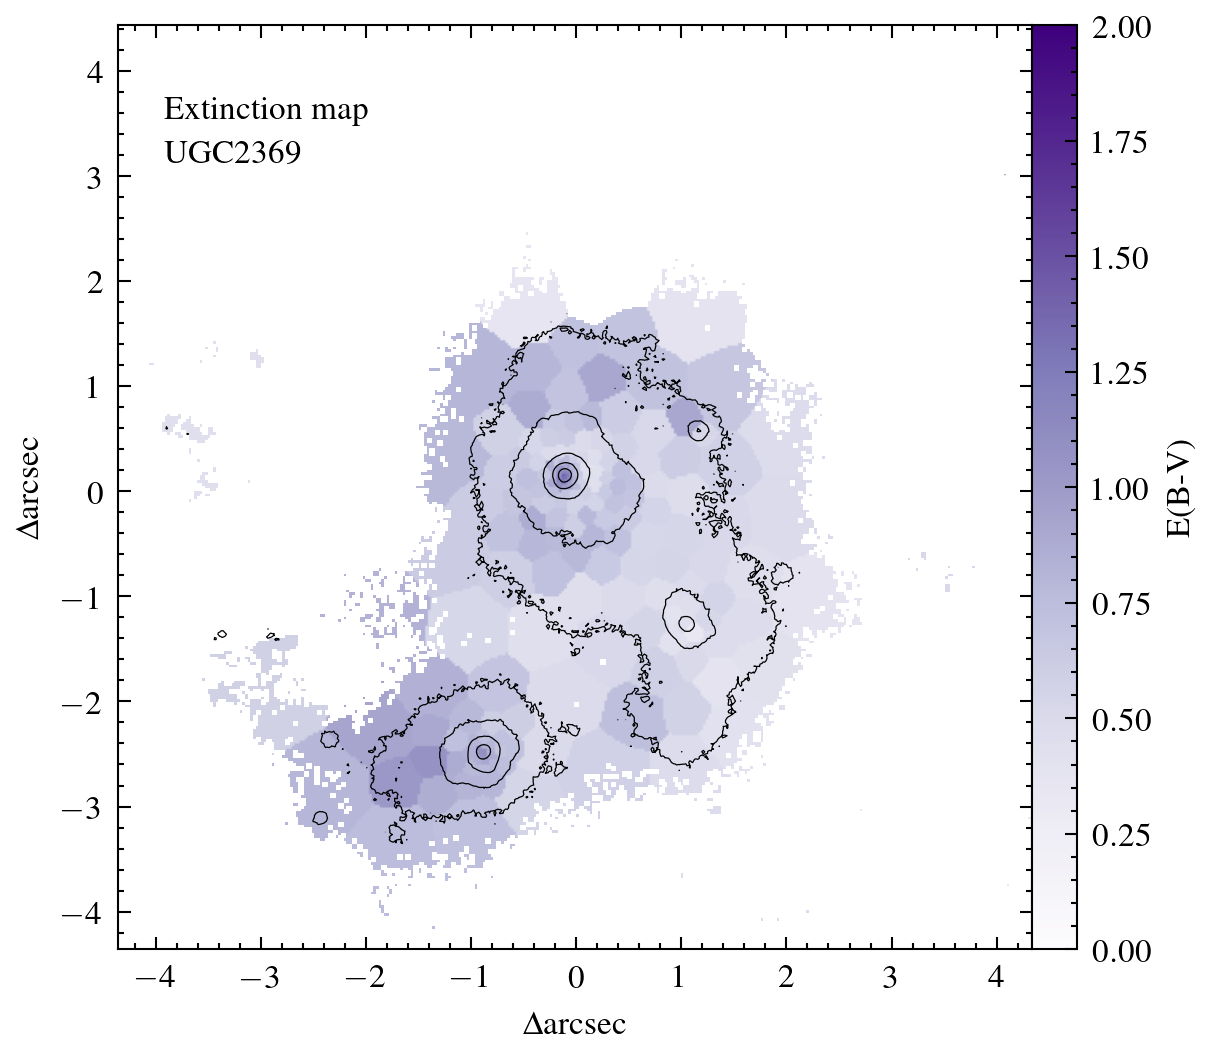

In [691]:
from astropy.stats import sigma_clipped_stats

EBV = np.full( (npixels_x, npixels_y), np.nan )

#2.5/1.163*np.log10

EBV[i,j] = 2.5/(Cex.k_lambda(x=[0.486268])-Cex.k_lambda(x=[0.656461]))*np.log10(result[:,4]/2.68)

fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=0
vmax=2
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(EBV), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"E(B-V)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"Extinction"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
fig.savefig(datapath+"/fig/MUSE_extinction_map.pdf")

In [541]:
np.nanmedian(10**(Cex.k_lambda(x=[0.6564])*0.77))

363.3875826681166

In [786]:
np.nanstd(Ha_SFR)

1.89223049132057

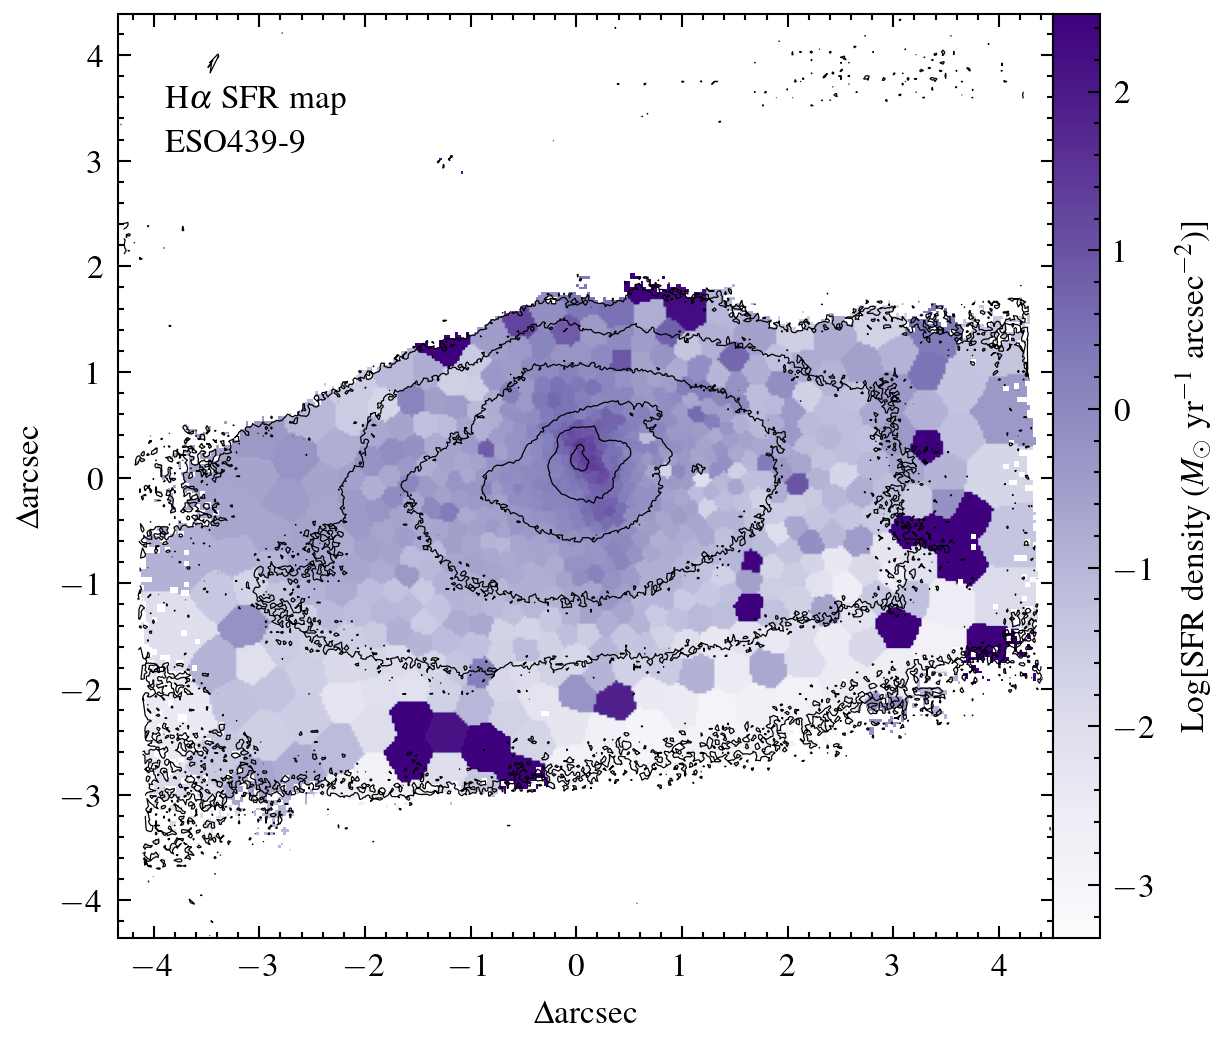

In [789]:
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import Planck18
#EBV = np.full( (npixels_x, npixels_y), np.nan )

#2.5/1.163*np.log10

#EBV[i,j] = 2.5/(Cex.k_lambda(x=[0.486268])-Cex.k_lambda(x=[0.656461]))*np.log10(result[:,4]/2.68)

Sld=Planck18.luminosity_distance(z=0.03145).to(u.cm).value**2*4*np.pi
image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,5]*1e-20
EBV[EBV<0]=0
Ha_SFR=np.log10(image*Sld*10**(0.4*Cex.k_lambda(x=[0.6564])*EBV)/10**41.27)#
#Ha_SFR=np.log10(image*10**(0.4*Cex.k_lambda(x=[0.6564])*EBV)*1e20)#

fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=np.nanmin(Ha_SFR)
vmax=np.nanmedian(Ha_SFR)+2*np.nanstd(Ha_SFR)
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(Ha_SFR), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"Log[SFR density ($M_{\odot}\rm ~yr^{-1}~arcsec^{-2}$)]")
#cb.set_label(r"Log[F$_\mathrm{H\alpha}$ ($10^{-20}\rm~erg~s^{-1}~cm^{-2}~arcsec^{-2}$)]")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=2.2
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.2 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"H$\alpha$ SFR"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
fig.savefig(datapath+"/fig/MUSE_SFR_map.pdf")

In [943]:
V=(500*u.Msun).to(u.kg)/(500*constants.u/u.cm**3)
print(V.to(u.pc**3))

40.75727852103357 pc3


In [536]:
np.nanmax(Cex.k_lambda(x=[0.6564])*EBV)

18.338505167295768

In [259]:
10**(Cex.k_lambda(x=[0.658528])-Cex.k_lambda(x=[0.656461]))

array([0.97001319])

## BPT diagrams

color: orange
length of data: (0,)
color: red
length of data: (122,)
color: [0.2, 0.4, 0.6]
length of data: (39378,)


(-1.2, 1.2)

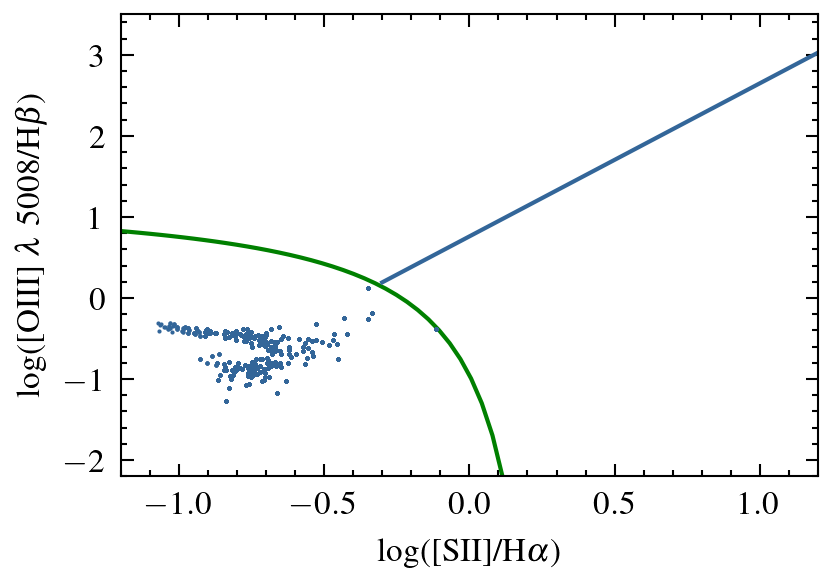

In [222]:
from dust_attenuation.averages import C00
Cex=C00()

fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)

Ax=Cex.k_lambda(x=[0.6725])-Cex.k_lambda(x=[0.656461])

Ay=Cex.k_lambda(x=[0.500824])-Cex.k_lambda(x=[0.486268])

xBPT=np.log10(result[:,4]/result[:,2]*10**Ax)

yBPT=np.log10(result[:,1]/result[:,3]*10**Ay)

# Kewley+01 ------------------------------------------
XK01 = np.linspace(-1.5,0.3)
YK01 = (0.72/( XK01  - 0.32  )) + 1.30

# Kewley+06 --------------------------------------
XK06 = np.linspace(-0.30,1.5)
YK06 = 1.89*XK06 + 0.76

# Regions --------------------------------------------
color=["orange","red",[0.2,0.4,0.6],"green"]


ax.plot(XK01,   YK01, '-' , color='green', lw=1, label='Kewley+01'    ) # Kewley+01
ax.plot(XK06, YK06, '-', color=color[2], lw=1, label='Kewley+06') # Schawinski+07
#ax.plot(Xkauff, Ykauff, '--', color='m', lw=1, label='Kauffmann+03' ) # Kauffmann+03
ax.set_xlabel(r'log([SII]/H$\alpha$)',fontsize=8)
ax.set_ylabel(r'log([OIII] $\lambda$ 5008/H$\beta$)',fontsize=8)
#ax.scatter(xBPT,yBPT,s=0.5)
xxmin, xxmax         = -1.2, 1.2   # Define the maximum and minimum limit in X-axis
yymin, yymax         = -2.2, 3.5   # Define the maximum and minimum limit in Y-axis
ax.tick_params(labelsize = 8)
ax.legend
#ax.set_yscale("log")



LINERs=(xBPT>np.min(XK06)) & (yBPT<(1.89*xBPT+0.76)) & (yBPT>((0.72/( xBPT  - 0.32  )) + 1.30))

AGNs= (xBPT>np.min(XK06)) & (yBPT>(1.89*xBPT+0.76))|(xBPT<np.min(XK06)) & (yBPT>(0.72/( xBPT  - 0.32  ) + 1.30))

SF =  (yBPT<(0.72/( xBPT  - 0.32  ) + 1.30)) & (xBPT < np.max(XK01))

#Composite = (yBPT > 0.61/(xBPT -0.05) + 1.3) & (yBPT<(0.61/( xBPT  - 0.47  ) + 1.19))

kind=np.array([LINERs, AGNs, SF])
for ii in range(3):
    print("color:",color[ii])
    print("length of data:",xBPT[kind[ii,:]].shape)
    ax.errorbar(xBPT[kind[ii,:]],yBPT[kind[ii,:]],fmt="o",mfc=color[ii],ms=1.0,mec="none")

ax.set_ylim(yymin, yymax)
ax.set_xlim(xxmin, xxmax)


color: orange
length of data: (0,)
color: red
length of data: (122,)
color: [0.2, 0.4, 0.6]
length of data: (24779,)
color: green
length of data: (14091,)


(-1.2, 1.2)

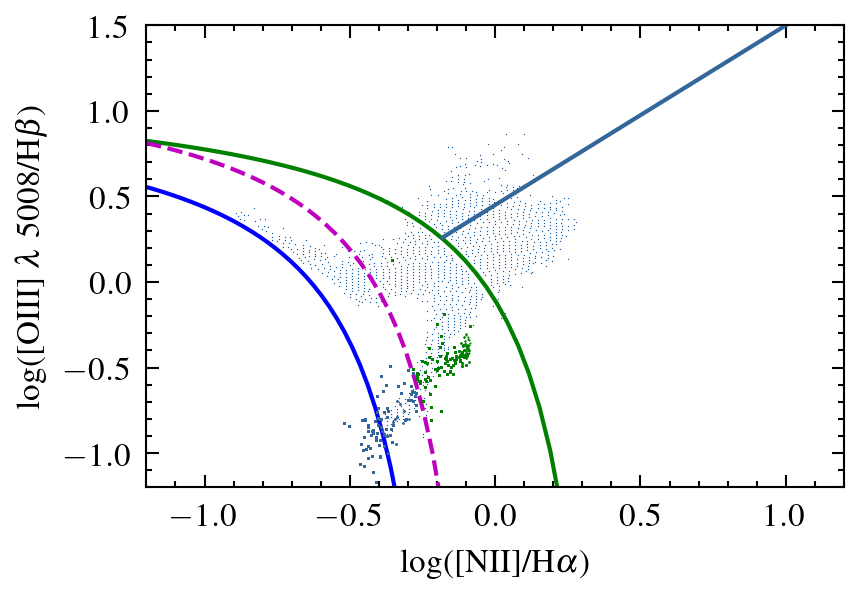

In [223]:

fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)

Ax=Cex.k_lambda(x=[0.658528])-Cex.k_lambda(x=[0.656461])

Ay=Cex.k_lambda(x=[0.500824])-Cex.k_lambda(x=[0.486268])

xBPT=np.log10(result[:,0]/result[:,2]*10**Ax)

yBPT=np.log10(result[:,1]/result[:,3]*10**Ay)

# Kewley+01 ------------------------------------------
Xkew = np.linspace(-1.5,0.3)
Ykew = (0.61/( Xkew  - 0.47  )) + 1.19

Xkew2 = np.linspace(-1.5,-0.2)

Ykew2=(0.61/( Xkew2  + 0.08  )) + 1.1
# Schawinski+07 --------------------------------------
XSch = np.linspace(-0.180,1.5)
YSch = 1.05*XSch + 0.45

# Kauffmann+03 ---------------------------------------
Xkauff = np.linspace(-1.5,0.)
Ykauff = 0.61/(Xkauff -0.05) + 1.3

# Regions --------------------------------------------
color=["orange","red",[0.2,0.4,0.6],"green"]


ax.plot(Xkew,   Ykew, '-' , color='green', lw=1, label='Kewley+01'    ) # Kewley+01
ax.plot(Xkew2,   Ykew2, '-' , color='blue', lw=1, label='Kewley+13'    ) # Kewley+01

ax.plot(XSch, YSch, '-', color=color[2], lw=1, label='Schawinski+07') # Schawinski+07
ax.plot(Xkauff, Ykauff, '--', color='m', lw=1, label='Kauffmann+03' ) # Kauffmann+03
ax.set_xlabel(r'log([NII]/H$\alpha$)',fontsize=8)
ax.set_ylabel(r'log([OIII] $\lambda$ 5008/H$\beta$)',fontsize=8)
#ax.scatter(xBPT,yBPT,s=0.5)
xxmin, xxmax         = -1.2, 1.2   # Define the maximum and minimum limit in X-axis
yymin, yymax         = -1.2, 1.5   # Define the maximum and minimum limit in Y-axis
ax.tick_params(labelsize = 8)
ax.legend
#ax.set_yscale("log")
NII = np.linspace(-0.5, 0.5)
BPT=np.genfromtxt("/disk/bifrost/yuanze/multiAGN/Line.csv",delimiter=",")
ax.scatter(BPT[:,0],BPT[:,1],s=0.1,lw=0)
#plt.scatter(data['log_NII_Ha'], data['log_OIII_Hb'],
#            c="black", s=0.1, lw=0)
#NII = np.linspace(-2.0, 0.35)
#ax.plot(NII, log_OIII_Hb_NII(NII), '-k')
#ax.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
#ax.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')

LINERs=(xBPT>np.min(XSch)) & (yBPT<(1.05*xBPT+0.45)) & (yBPT>((0.61/( xBPT  - 0.47  )) + 1.19))

AGNs= (xBPT>np.min(XSch)) & (yBPT>(1.05*xBPT+0.45))|(xBPT<np.min(XSch)) & (yBPT>(0.61/( xBPT  - 0.47  ) + 1.19))

SF = (xBPT<np.min(XSch)) & (yBPT<(0.61/(xBPT -0.05) + 1.3)) & (xBPT < np.max(Xkauff))

Composite = (yBPT > 0.61/(xBPT -0.05) + 1.3) & (yBPT<(0.61/( xBPT  - 0.47  ) + 1.19)) & (xBPT < np.max(Xkew))

kind=np.array([LINERs, AGNs, SF,Composite])
for ii in range(4):
    print("color:",color[ii])
    print("length of data:",xBPT[kind[ii,:]].shape)
    ax.errorbar(xBPT[kind[ii,:]],yBPT[kind[ii,:]],fmt="o",mfc=color[ii],ms=0.5,mec="none")

ax.set_ylim(yymin, yymax)
ax.set_xlim(xxmin, xxmax)


In [738]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_sdss_spectrum
from astroML.datasets.tools.sdss_fits import log_OIII_Hb_NII

data = fetch_sdss_spectrum()

i = np.where((data['lineindex_cln'] == 4) | (data['lineindex_cln'] == 5))

plt.scatter(data['log_NII_Ha'], data['log_OIII_Hb'],
            c=data['lineindex_cln'], s=9, lw=0)

NII = np.linspace(-2.0, 0.35)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k')
plt.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
plt.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')
plt.xlim(-2.0, 1.0)
plt.ylim(-1.2, 1.5)

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.show()

TypeError: fetch_sdss_spectrum() missing 3 required positional arguments: 'plate', 'mjd', and 'fiber'

(-1.2, 1.2)

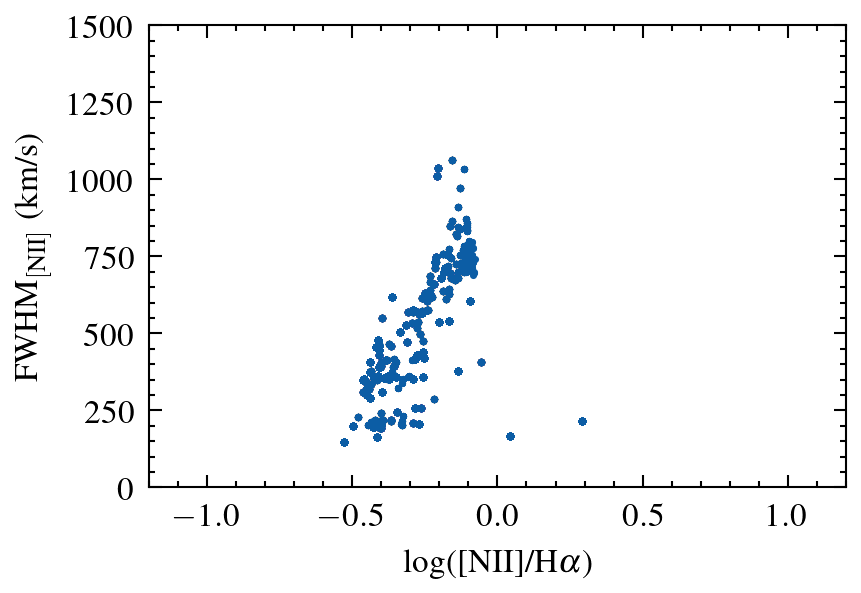

In [615]:

fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)

Ax=Cex.k_lambda(x=[0.658528])-Cex.k_lambda(x=[0.656461])

#Ay=Cex.k_lambda(x=[0.500824])-Cex.k_lambda(x=[0.486268])



xBPT=np.log10(result[:,0]/result[:,2]*10**Ax)



yBPT=result[:,5]

ax.scatter(xBPT,yBPT,s=0.5)


ax.set_xlabel(r'log([NII]/H$\alpha$)',fontsize=8)
ax.set_ylabel(r'FWHM$_\mathrm{[NII]}$ (km/s)',fontsize=8)
#ax.scatter(xBPT,yBPT,s=0.5)
xxmin, xxmax         = -1.2, 1.2   # Define the maximum and minimum limit in X-axis
yymin, yymax         = 0, 1500   # Define the maximum and minimum limit in Y-axis
ax.tick_params(labelsize = 8)
ax.legend
#ax.set_yscale("log")
ax.set_ylim(yymin, yymax)
ax.set_xlim(xxmin, xxmax)


Dir exists


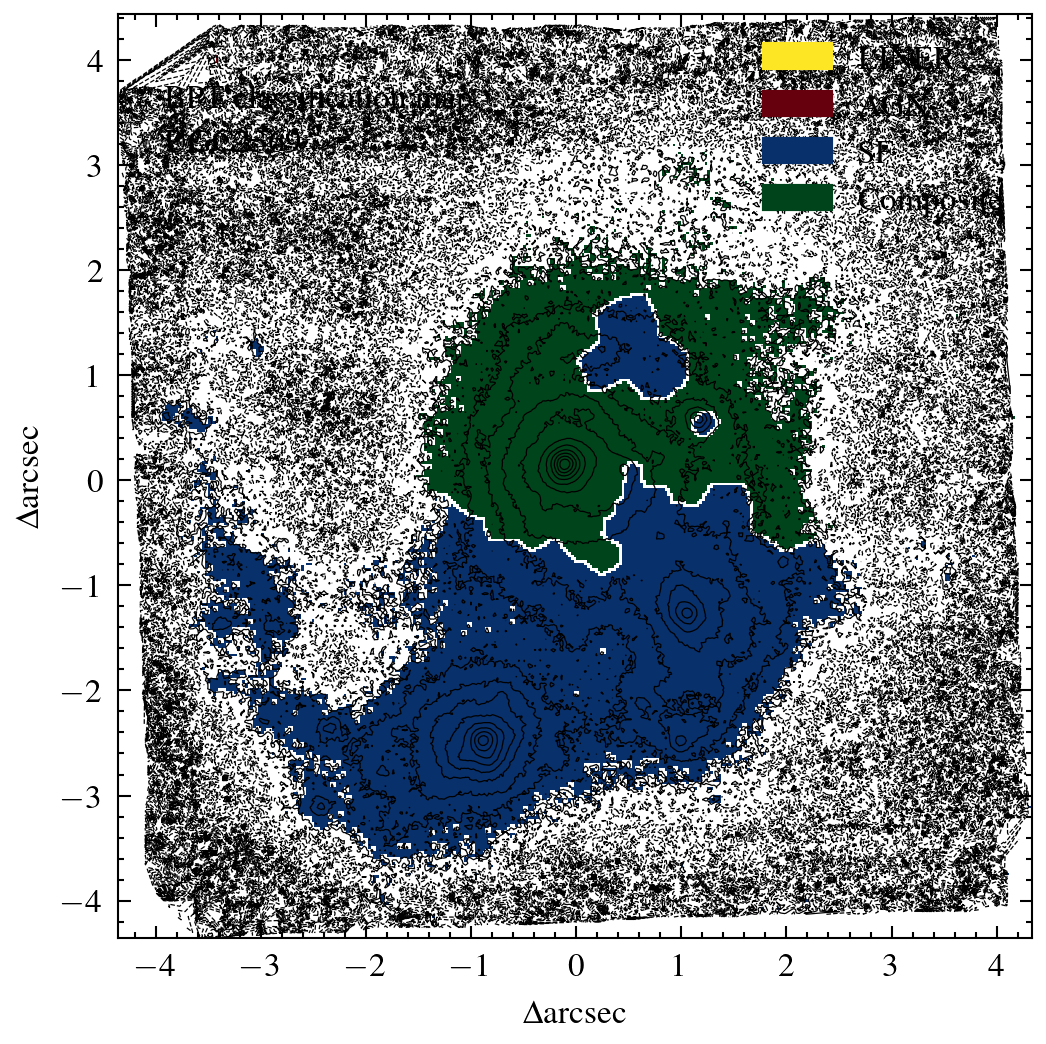

In [225]:
from astropy.stats import sigma_clipped_stats
import matplotlib.patches as mpatches


ramask=np.full((npixels_x, npixels_y), np.nan )
blank_image=np.full((npixels_x, npixels_y), np.nan )
color=[np.array([0.1, 0.2, 0.5]),np.array([0.1, 0.8, 0.3]),np.array([0.1, 0.8, 0.5]),np.array([0.8, 0.3, 0.1])]
cmaps=[plt.cm.viridis, plt.cm.Reds, plt.cm.Blues, plt.cm.Greens]


fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)

vmin=0
vmax=1.
legend_patches=[]
labels=["LINER", "AGN", "SF","Composite"]
for ii in range(4):
    blank_image=np.full((npixels_x, npixels_y), np.nan )
    ramask=np.full((npixels_x, npixels_y), False )
    ramask[i,j]= kind[ii,:]
    # BPTclass.append(ramask.copy())
    blank_image[ramask]=1
    cmap=cmaps[ii]
    cmap.set_bad(color='none') 
    rescmap=cmap.resampled(10)
    legend_patches.append(mpatches.Patch(color=rescmap(10)[:3], label=labels[ii]))
    ax.imshow(np.rot90(blank_image),cmap=cmap, interpolation=None,vmin=vmin,vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )



# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.0, 1))


#im=ax.imshow(np.rot90(BPTclass[0]), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            #extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
#divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
#cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
#cb=fig.colorbar(im, cax=cax)
#cb.set_label(r"E(B-V)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=2.2
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.2 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"BPT classification"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
try:
    os.mkdir(datapath+"/fig")
except:
    print("Dir exists")
#fig.savefig(datapath+"/fig/MUSE_BPT_map.pdf")

In [921]:
5.89e56/(0.5/(300*u.km.to(u.kpc)))

1.1452914008896386e+43

In [918]:
0.5/(500*u.km.to(u.kpc))*u.s.to(u.Myr)

0.9777922216807892

In [919]:
kpc_per_pix/pixelsize

0.6451820272421236

In [ ]:
from astropy.stats import sigma_clipped_stats
import matplotlib.patches as mpatches


ramask=np.full((npixels_x, npixels_y), np.nan )
blank_image=np.full((npixels_x, npixels_y), np.nan )
color=[np.array([0.1, 0.2, 0.5]),np.array([0.1, 0.8, 0.3]),np.array([0.1, 0.8, 0.5]),np.array([0.8, 0.3, 0.1])]
cmaps=[plt.cm.viridis, plt.cm.Reds, plt.cm.Blues, plt.cm.Greens]


fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)

vmin=0
vmax=1.
legend_patches=[]
labels=["LINER", "AGN", "SF"]
for ii in range(3):
    blank_image=np.full((npixels_x, npixels_y), np.nan )
    ramask=np.full((npixels_x, npixels_y), False )
    ramask[i,j]= kind[ii,:]
    # BPTclass.append(ramask.copy())
    blank_image[ramask]=1
    cmap=cmaps[ii]
    cmap.set_bad(color='none') 
    rescmap=cmap.resampled(10)
    legend_patches.append(mpatches.Patch(color=rescmap(10)[:3], label=labels[ii]))
    ax.imshow(np.rot90(blank_image),cmap=cmap, interpolation=None,vmin=vmin,vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )



# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.0, 1))


#im=ax.imshow(np.rot90(BPTclass[0]), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            #extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
#divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
#cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
#cb=fig.colorbar(im, cax=cax)
#cb.set_label(r"E(B-V)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX ))-0.4, 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"BPT classification"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
fig.savefig(datapath+"/fig/MUSE_SIIBPT_map.pdf")

## iterate over field

In [350]:
"""
fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name('OIII5007c', 'narrow')
print("Narrow [OIII]5007:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("S/N", np.round(snr, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")

fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name('NII6549w', 'narrow')

print("Narrow Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("S/N", np.round(snr, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")
"""
from plotbin.display_bins import display_bins
from matplotlib.gridspec import GridSpec
#tbin=225

line="OIII5007"
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
try:
    os.mkdir(datapath+f"/field_scan_2")
except:
    print("Dir exists")
for tbin in range(nbins):
    q=qlist[tbin]
    fig=plt.figure(figsize=(8,4), dpi=300)
    gs=GridSpec(2,2,wspace=None)
    ax1=fig.add_subplot(gs[0,0])
    ax2=fig.add_subplot(gs[1,0])
    ax3=fig.add_subplot(gs[:,1])
    #q=q_mle
    
    #q.set_mpl_style( tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0)
    
    if q.MCMC:
        gauss_result = q.gauss_result[::2]
    else:
        gauss_result = q.gauss_result
    #plt.subplot(111)
    # Plot individual line components
    if q.num_abs_line > 0:
        start_emission=q.num_abs_line
    for p in range(start_emission,int(len(gauss_result) / 3)):
        if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
            color = 'g'  # narrow
        else:
            color = 'r'  # broad
        ax1.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)
        ax2.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)


    
    # Plot total line model
    ax1.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
    ax1.step(q.wave, q.line_flux, 'k',lw=0.5)
    
    ax2.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
    ax2.step(q.wave, q.line_flux, 'k',lw=0.5)
    #ax.step(q.wave,q.err)
    ax1.set_xlim(5800, 5950)
    ax2.set_xlim(4800, 5200)
    yup_1=10*np.nanmax(q.line_flux[(q.wave>5800)&(q.wave<6000)])
    ylow_1=-1.1*np.abs(np.min(q.line_flux))
    yup_2=np.nanmax(q.line_flux[q.wave<5200])
    ax1.set_ylim(ylow_1, yup_1)
    ax2.set_ylim(1e-4, yup_2)
    ax1.axvline(5890)
    ax1.axvline(5896)
    #ax.set_yscale("log")
    ax2.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize=10)
    ax2.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize=10)
    #plt.subplot(122)
    #
    #mag=-2.5*np.log10(signal/np.sum(signal).ravel())
    #levels=[8,9,10,13,15,18,20,25,30,35,40]
    for ii in range(4):
        blank_image=np.full((npixels_x, npixels_y), np.nan )
        ramask=np.full((npixels_x, npixels_y), False )
        ramask[i,j]= kind[ii,:]
        # BPTclass.append(ramask.copy())
        blank_image[ramask]=1
        cmap=cmaps[ii]
        cmap.set_bad(color='none') 
        rescmap=cmap.resampled(10)
        legend_patches.append(mpatches.Patch(color=rescmap(10)[:3], label=labels[ii]))
        ax3.imshow(np.rot90(blank_image),cmap=cmap, interpolation=None,vmin=vmin,vmax=vmax, \
                extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )

    #ax=plt.gca()
    ax3.set_xlabel(r"$\Delta$arcsec")
    ax3.set_ylabel(r"$\Delta$arcsec")
    #RApix=[3.4,4.4,5.3]
    #Decpix=[1.8,4.4,3.]
    #for io in range(3):
    #    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
    ax3.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax3.transAxes)
    ax3.text(0.05,0.9,"{} BPT map".format(line),color="k",transform=ax3.transAxes)
    ind=(binNum_long==tbin)
    px=np.mean(X[ind])
    py=np.mean(Y[ind])
    ax3.plot(px, py,"+",c="m",ms=10,lw=0.01)
    fig.savefig(datapath+f"/field_scan_2/bin{tbin:d}.pdf")
    plt.tight_layout()
    plt.close()



Dir exists


## Show current q

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-1.3869378764392701, 1.0)

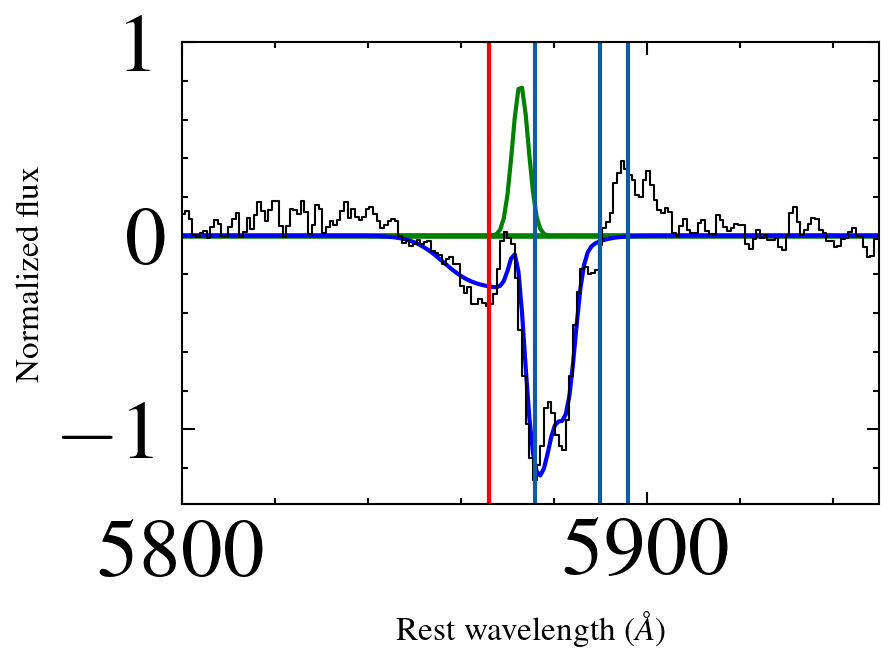

In [77]:
lines={'[N II]':[6548.,6583.],"[S II]":[6716.,6731.] ,'[O III]':[4959,5007],'[O II]':[3727], r"H$\alpha$":[6563], r"H$\beta$":[4861.],"CaII":[8498, 8542, 8662]}#,"Fe II":[6491.28,6385.45,6598.3]}
import scienceplots
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
bin_sel=0

q=qlist[bin_sel]
rlinec= (1+0.0312)/(1+0.0312)


if q.MCMC:
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result

# Plot individual line components
fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)


if q.num_abs_line > 0:
    start_emission=q.num_abs_line
for p in range(start_emission,int(len(gauss_result) / 3)):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)


    



ax.plot(q.wave*rlinec, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
ax.step(q.wave*rlinec, q.line_flux, 'k',lw=0.5)
#ax.plot(np.exp(Lambda)*rlinec,Spectra[bin_sel,:],lw=0.5,label="Data")
#ax.plot(np.exp(kinLambda)*rlinec,kinBestfit[bin_sel,:],lw=0.5,label="Model")
ax.set_ylabel("Normalized flux")
ax.set_xlabel(r"Rest wavelength ($\AA$)")
xlow=5800
xhigh=5950
yup=1#np.max(q.line_flux)*1.2
ylow=-1.1*np.abs(np.min(q.line_flux))

keys=lines.keys()
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(line,ls=":",c="m")
#            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
#            mask= mask | masktmp
           # print(x[mask])
    if line < xhigh and line > xlow:
        ax.text(line, 0.85*yup,key, rotation=90,verticalalignment='bottom',horizontalalignment='center')
ax.axvline(5890)
ax.axvline(5896)
ax.axvline(5876)
ax.axvline(5866,color="r")

#rstring=rf"V={result[idx][0][0]:.1f}$\pm${result[idx][0][2]:.1f}, $\sigma$={result[idx][0][1]:.1f}$\pm${result[idx][0][3]:.1f} km/s"
#ax.text(0.05,0.97, rstring, color='black', ha='left', va='top',transform=ax.transAxes)
ax.legend(loc="lower left")
ax.set_xlim([xlow,xhigh])
ax.set_ylim([ylow,yup])
#fig.savefig(datapath+f"/fig/fitted_spec_kin_obj{obj}.pdf")

In [999]:
q.gauss_result_name

array(['NaI5890_1_scale', 'NaI5890_1_centerwave', 'NaI5890_1_sigma',
       'NaI5896_1_scale', 'NaI5896_1_centerwave', 'NaI5896_1_sigma',
       'NaI5890w_1_scale', 'NaI5890w_1_centerwave', 'NaI5890w_1_sigma',
       'NaI5896w_1_scale', 'NaI5896w_1_centerwave', 'NaI5896w_1_sigma',
       'OI6300_1_scale', 'OI6300_1_centerwave', 'OI6300_1_sigma',
       'Ha_na_1_scale', 'Ha_na_1_centerwave', 'Ha_na_1_sigma',
       'NII6549_1_scale', 'NII6549_1_centerwave', 'NII6549_1_sigma',
       'NII6585_1_scale', 'NII6585_1_centerwave', 'NII6585_1_sigma',
       'SII6718_1_scale', 'SII6718_1_centerwave', 'SII6718_1_sigma',
       'SII6732_1_scale', 'SII6732_1_centerwave', 'SII6732_1_sigma',
       'HeI5876_1_scale', 'HeI5876_1_centerwave', 'HeI5876_1_sigma',
       'Ha_naw_1_scale', 'Ha_naw_1_centerwave', 'Ha_naw_1_sigma',
       'NII6549w_1_scale', 'NII6549w_1_centerwave', 'NII6549w_1_sigma',
       'NII6585w_1_scale', 'NII6585w_1_centerwave', 'NII6585w_1_sigma',
       'SII6718w_1_scale', 'SII671

In [1000]:
q.gauss_result

array([1.00000000e+01, 8.67980226e+00, 1.46099656e-03, 5.00000000e+00,
       8.68081601e+00, 2.30000027e-06, 9.99807094e+00, 8.68118544e+00,
       7.83844496e-04, 4.99903547e+00, 8.68219919e+00, 2.30000027e-06,
       3.71201692e+01, 8.74836905e+00, 3.16321234e-04, 1.84172143e+03,
       8.78946574e+00, 3.16321234e-04, 4.60279688e+02, 8.78721412e+00,
       3.16321234e-04, 1.44769912e+03, 8.79260905e+00, 3.16321234e-04,
       2.99962877e+01, 8.81260569e+00, 3.16321234e-04, 1.09362299e+02,
       8.81474383e+00, 3.16321234e-04, 3.19447524e+00, 8.67858394e+00,
       3.16321234e-04, 8.36469442e+02, 8.78908534e+00, 9.76821989e-04,
       2.73762930e+02, 8.78683371e+00, 9.76821989e-04, 7.30809260e+02,
       8.79222865e+00, 9.76821989e-04, 6.92785956e+01, 8.81222529e+00,
       9.76821989e-04, 5.40564798e+01, 8.81436343e+00, 9.76821989e-04,
       1.48105818e+02, 8.48936255e+00, 3.16321234e-04, 1.40366153e+02,
       8.48898215e+00, 9.76821989e-04, 1.81066329e+01, 8.50923808e+00,
      

## Extract properties around object 3

In [978]:
def circularly_averaged_radial_distribution(Map2d,center,num_bins,rmax,Type="Mstar",pix2world=None,**kwag):
    # Determine the center of the 2D map
    # all in kpc unit
    #center = np.array(stellar_mass_map.shape) // 2
    total_in_rmax=0
    # Create coordinate grids
    y, x = np.indices(Map2d.shape)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    
    #r=np.rot90(r.T)
    # Define the bins
    r_max = rmax
    bins = np.linspace(0, r_max, num_bins + 1)
    
    # Digitize the radial distances into bins
    bin_indices = np.digitize(r, bins) - 1
    #print(r)
    #print(bin_indices)
    fig=plt.figure(dpi=300)
    im=plt.imshow(bin_indices,origin="lower")
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax, with 2% width and no padding
    cax = divider.append_axes("right", size="5%", pad=0.0)
    cb=fig.colorbar(im, cax=cax)
    # Calculate the circularly averaged stellar mass in each bin
    radial_distribution = np.zeros(num_bins)
    omegasum=0
    if Type=="NaImdot":
        mdot_temp=1.4*constants.u.to(u.Msun).value*Map2d/u.cm.to(u.kpc)**2*np.abs(vshift)*u.km.to(u.kpc)/u.s.to(u.yr)*Rshell #\mu m_p N_i v_i, convert NH from cm-2 to kpc-2
    if Type=="NaIEdot":
        mdot_temp=1.4*constants.u.to(u.g).value*Map2d*np.abs(vshift)*u.km.to(u.cm)*Rshell*u.kpc.to(u.cm)*(np.abs(vshift)*u.km.to(u.cm))**2 #\mu m_p N_i v_i*v_i**2, convert NH from cm-2 to kpc-2
    for i in range(num_bins):
        if Type=="Mstar":
            radial_distribution[i] = (10**Map2d[bin_indices == i]).mean()
            total_in_rmax+=np.nansum(10**Map2d[bin_indices == i])
        elif Type=="mag":
            radial_distribution[i] = np.nanmean(10**(Map2d[bin_indices == i]/-2.5))
            total_in_rmax+=np.nansum(10**Map2d[bin_indices == i])
        elif Type=="NaImdot":
            costheta2=np.sqrt(1-(bins[i]*pix2world/Rshell)**2)
            Omega=(pix2world/Rshell)**2/costheta2 #solid angle element for each pixel at distance bins[i] away from center
            #vr=vobs/costheta2=vobs/np.sqrt(1-(bins[i]*pix2world/Rshell)**2))
            radial_distribution[i]=np.nanmean(mdot_temp[bin_indices == i]/costheta2)# Mdot per Omega, here cos(theta_2) is a velocity correction factor
            total_in_rmax+=np.nansum(mdot_temp[bin_indices == i]/costheta2*Omega)#
        elif Type=="NaIEdot":
            costheta2=np.sqrt(1-(bins[i]*pix2world/Rshell)**2)
            Omega=(pix2world/Rshell)**2/costheta2 #solid angle element for each pixel at distance bins[i] away from center
            print(costheta2)
            omegasum+=np.nansum(np.ones(np.shape(mdot_temp[bin_indices == i]))*Omega)
            #vr=vobs/costheta2=vobs/np.sqrt(1-(bins[i]*pix2world/Rshell)**2))
            radial_distribution[i]=np.nanmean(mdot_temp[bin_indices == i]/costheta2**3)
            total_in_rmax+=np.nansum(mdot_temp[bin_indices == i]/costheta2*Omega)
        elif Type=="simple sum":
            costheta2=np.sqrt(1-(bins[i]*pix2world/Rshell)**2)
            radial_distribution[i]=np.nanmean(Map2d[bin_indices == i]/costheta2)
            total_in_rmax+=np.nansum(Map2d[bin_indices == i])
        else:
            raise("Error: invalid switches")
   # if Type=="mdot":
        

    return bins[1:], radial_distribution,bin_indices, total_in_rmax,omegasum



1.0
0.999425455927332
0.9976998385397394
0.9948171578737471
0.9907673144027758
0.9855359196340278
0.979104034513187
0.9714478142557232
0.9625380434848045
0.952339539450085
0.9408103929887018
0.927901005831022
0.9135528674357056
0.8976969925809536
0.8802519089947427
0.8611210367886735
0.8401892290563014
0.8173181297117759
0.7923398220460712
0.7650479370311088
0.7351848626177105
0.7024227376729769
0.6663340802397014
0.6263441501993042
0.5816488342634237
0.5310614109707295
0.47269394110307256
0.4031815789442763
0.31523593252602916
0.18410454807587362
total mass 8.20e+42
radius of circle: 0.7626000000000001


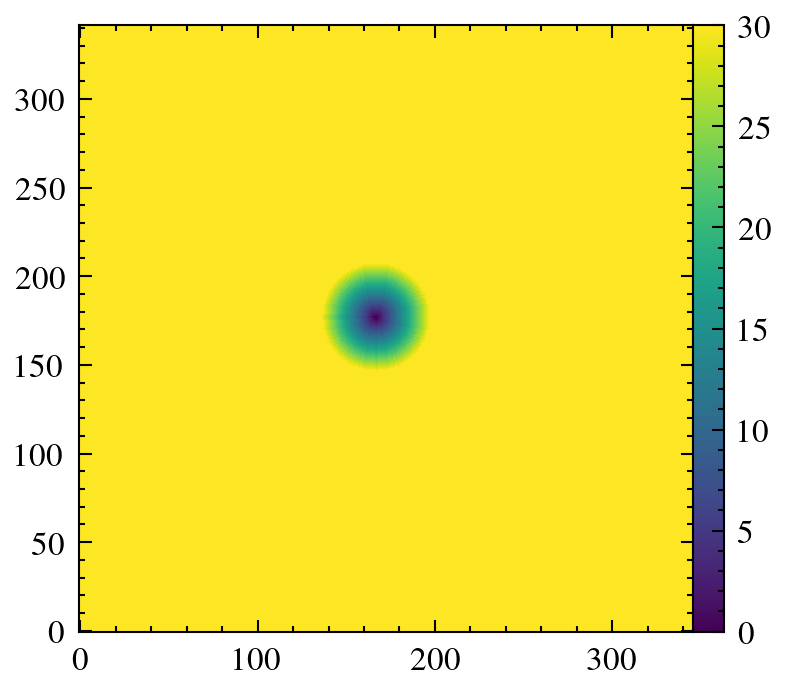

In [976]:

# Example usage
pixscale=2.542e-02 #MUSE pixel scale
kpc_per_pix=pixscale*Planck18.kpc_proper_per_arcmin(0.0312).value/60
#stellar_mass_map = Zm  # Replace with your actual stellar mass map
num_bins = 30  # Number of radial bins
num_of_pix = 30 #radius of circle (pix)

Rshell=0.75*Planck18.kpc_proper_per_arcmin(0.0312).value/60
obj3=np.array([-0.1025,0.1525])
obj2=np.array([1.2,-1.4])
obj1=np.array([-0.75,-2.6])
#obj=objects['x']*pix_scale]
center=(obj3-np.array([ymin,xmin]))/pixscale
#center=(np.array([-0.9,-1.25])-np.array([ymin,xmin]))/pix_scale
radii, radial_distribution,bin_indices,total_in_rmax,omegasum = circularly_averaged_radial_distribution(NH, center,num_bins,num_of_pix,Type="NaIEdot",
                                                                                        pix2world=kpc_per_pix,Rshell=Rshell,vshift=vshift)#wcs.pixel_scale_matrix[1,1]*3600)
print("total mass %.2e"%total_in_rmax)
print("radius of circle:",pixscale*num_of_pix)

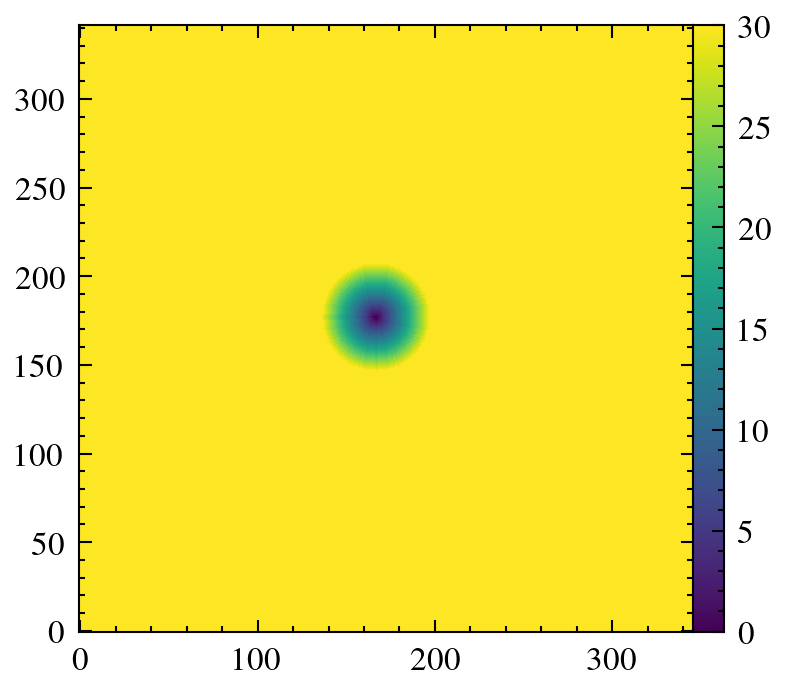

In [980]:
radii, radial_distribution,bin_indices,total_in_rmax,omegasum = circularly_averaged_radial_distribution(vshift, center,num_bins,30,Type="simple sum",pix2world=kpc_per_pix,Rshell=Rshell)#wcs.pixel_scale_matrix[1,1]*3600)


In [977]:
print("total mass %.2e"%total_in_rmax)
print("radius of circle:",pixscale*num_of_pix)

total mass 8.20e+42
radius of circle: 0.7626000000000001


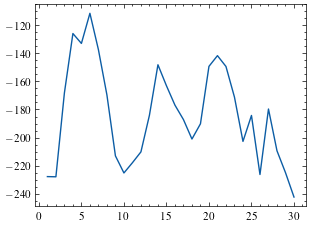

In [981]:
plt.plot(radii,radial_distribution)

In [983]:
7.8e19/u.pc.to(u.cm)

25.27807845766605

In [985]:
q.result

AttributeError: 'QSOFit' object has no attribute 'result'